## CPA Hyperparameter Optimization with Optuna

CPA-Predicting perturbation responses for unseen cell-types (context transfer)

### Functions

In [1]:
import optuna

In [ ]:
import cpa
from rdkit import Chem
import scanpy as sc
from pandas import CategoricalDtype
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.sparse import issparse
from optuna.samplers import GridSampler
import scipy.sparse as sparse
from scipy.spatial.distance import cdist


Global seed set to 0


### Loading the dataset, standardizing condition labels, and filtering out stimulated cells of a specific cell line to construct a clean training subset for CPA model training.

In [ ]:
# loading the data directly from the file
adata = sc.read('./plate9_preprocessed_for_CPA_pred_cell_final.h5ad') 

# renaming the 'label' column to 'condition'
adata.obs.rename(columns={"label": "condition"}, inplace=True) 

# Renaming the categories in the 'condition' column
if isinstance(adata.obs["condition"].dtype, CategoricalDtype): 
    adata.obs["condition"] = (
        adata.obs["condition"]
        .cat.rename_categories({"ctrl": "control", "stim": "stimulated"})
    )
else:
    adata.obs["condition"] = (
        adata.obs["condition"]
        .map({"ctrl": "control", "stim": "stimulated"})
        .astype("category")
    )
    
# Creating a training set by excluding 'stimulated' cells of the specified cell type (CVCL_0546 in this case)
celltype_to_train = 'CVCL_0546' 

# Filtering the AnnData object to create a training set
train_adata = adata[~(                  
    (adata.obs['cell_line'] == celltype_to_train) &
    (adata.obs['condition'] == 'stimulated')
)].copy()

### Defining Search Space for Hyperparameter Optimization & Metrics - Running Optuna Optimization

In [ ]:
SEED = 42
adata.obs["cell_type"] = adata.obs["cell_line"]        #on Tahoe dataset is being mentioned as cell line

#Setup CPA-specific keys---------------------------------------------------------------
cpa.CPA.setup_anndata(adata,
                          perturbation_key='condition',
                          control_group='control' ,                                    
                          dosage_key='log_dose',
                          categorical_covariate_keys=['cell_line'],)

# Choose which cell type to hold out
cell_line_holdout = 'CVCL_0546'

# Initialize all as train
adata.obs['split_CVCL_0546'] = 'train'

# Mark OOD on that cell type
adata.obs.loc[adata.obs['cell_line'] == cell_line_holdout, 'split_CVCL_0546'] = 'ood'

# Define Train / Valid / OOD Splits
train_idx = adata.obs.index[adata.obs['split_CVCL_0546'] == 'train']
n_val = max(1, int(0.05 * len(train_idx)))
val_idx = np.random.choice(train_idx, size=n_val, replace=False)
adata.obs.loc[val_idx, 'split_CVCL_0546'] = 'valid'

# Inspect counts
print(adata.obs['split_CVCL_0546'].value_counts())


# Define Search Space for Hyperparameter Optimization ------------------------------------
search_space = {
    "n_latent": [32, 64, 128],
    "n_hidden_encoder": [128, 256, 512],
    "n_layers_encoder": [1, 2, 3],
    "dropout_rate_encoder": [0.0, 0.05, 0.1, 0.3],
    "lr": [1e-4, 3e-4, 1e-3]     
}
sampler = GridSampler(search_space)    


# Define Evaluation Metrics---------------------------------------------------------------
def bootstrap_metrics(X, mask_true, mask_pred, X_pca=None, n_boot=10):
    # Mean expression across cells
    x_true = X[mask_true].mean(axis=0)
    x_pred = X[mask_pred].mean(axis=0)

    r2 = r2_score(x_true, x_pred)
    mse = mean_squared_error(x_true, x_pred)
    pearson = pearsonr(x_true, x_pred)[0]

    return {
        "R2": r2,
        "MSE": mse,
        "Pearson": pearson
    }

def energy_d(X1, X2):
    """
    Compute the energy distance between two distributions.
    X1, X2: numpy arrays (n_cells × n_features), e.g. PCA embeddings
    """
    d1 = cdist(X1, X1, metric='euclidean')
    d2 = cdist(X2, X2, metric='euclidean')
    d12 = cdist(X1, X2, metric='euclidean')

    return 2 * d12.mean() - d1.mean() - d2.mean()
def mean_var_kde_distance(X_ref, X_pred):
    """
    Simple distance based on mean and variance of expression profiles.
    """
    mean_diff = np.linalg.norm(X_ref.mean(axis=0) - X_pred.mean(axis=0))
    var_diff = np.linalg.norm(X_ref.var(axis=0) - X_pred.var(axis=0))
    return mean_diff + var_diff


# Define Optuna Objective Function -------------------------------------------------------
def objective(trial: optuna.trial.Trial) -> float:
    n_latent = trial.suggest_categorical("n_latent", search_space["n_latent"])
    n_hidden_encoder = trial.suggest_categorical("n_hidden_encoder", search_space["n_hidden_encoder"])
    n_layers_encoder = trial.suggest_categorical("n_layers_encoder", search_space["n_layers_encoder"])
    dropout_rate_encoder = trial.suggest_categorical("dropout_rate_encoder", search_space["dropout_rate_encoder"])
    lr = trial.suggest_categorical("lr", search_space["lr"])


    label = f"lat{n_latent}_enc{n_hidden_encoder}x{n_layers_encoder}_do{dropout_rate_encoder}_lr{lr}"
    print(f"\n🔧  Trial {trial.number:02d} – {label}")

    # (a) build training set (hide CVCL_0546 cells)
    train_adata = adata[~(
        (adata.obs["cell_line"] == "CVCL_0546") &
        (adata.obs["condition"] == "stimulated")
    )].copy()
    

    # Set-up + train ---------------------------------------------------------------------
    model_params = {
        "n_latent": n_latent,
        "recon_loss": "nb",
        "doser_type": "linear",
        "n_hidden_encoder": n_hidden_encoder,
        "n_layers_encoder": n_layers_encoder,
        "n_hidden_decoder": 128,
        "n_layers_decoder": 2,
        "use_batch_norm_encoder": True,
        "use_layer_norm_encoder": False,
        "use_batch_norm_decoder": False,
        "use_layer_norm_decoder": True,
        "dropout_rate_encoder": dropout_rate_encoder,
        "dropout_rate_decoder": 0.05,
        "variational": False,
        "seed": 6977,
    }

    trainer_params = {
        "n_epochs_kl_warmup": None,
        "n_epochs_pretrain_ae": 30,
        "n_epochs_adv_warmup": 50,
        "n_epochs_mixup_warmup": 0,
        "mixup_alpha": 0.0,
        "adv_steps": None,
        "n_hidden_adv": 64,
        "n_layers_adv": 3,
        "use_batch_norm_adv": True,
        "use_layer_norm_adv": False,
        "dropout_rate_adv": 0.3,
        "reg_adv": 20.0,
        "pen_adv": 5.0,
        "lr": lr,
        "wd": 4e-07,
        "adv_lr": 0.0003,
        "adv_wd": 4e-07,
        "adv_loss": "cce",
        "doser_lr": 0.0003,
        "doser_wd": 4e-07,
        "do_clip_grad": True,
        "gradient_clip_value": 1.0,
        "step_size_lr": 10,
    }

    model = cpa.CPA(
        adata                = adata,
        split_key            = "split_CVCL_0546",   
        train_split          = "train",
        valid_split          = "valid",
        test_split           = "ood",
        use_rdkit_embeddings = False,
        **model_params,
        )

    model.train(max_epochs= 40,
                use_gpu=False,
                train_size= 0.8,
                validation_size= 0.2,
                batch_size=32,
                plan_kwargs=trainer_params,
                early_stopping_patience=5,
                check_val_every_n_epoch=5,
            )

    
    #Generate Counterfactual Predictions for CVCL_0546------------------------------------
    # 1. Get control cells of CVCL_0546
    ctrl = adata[(adata.obs["cell_line"] == "CVCL_0546") & 
                (adata.obs["condition"] == "control")].copy()

    # 2. Save true X
    ctrl.obsm["X_true"] = ctrl.X.copy()

    # 3. Set condition to "stimulated" for counterfactual prediction
    ctrl.obs["condition"] = "stimulated"

    # 4. Predict using modified adata
    model.predict(adata=ctrl)

    # 5. Extract prediction
    pred = ctrl.copy()
    pred.obs["condition"] = "predicted"
    pred.X = pred.obsm["CPA_pred"]

    # Predict held-out stimulation 
    ctrl = adata[(adata.obs["cell_line"]=="CVCL_0546") &
                 (adata.obs["condition"]=="control")]
    stim = adata[(adata.obs["cell_line"]=="CVCL_0546") &
                 (adata.obs["condition"]=="stimulated")]
    eval_ad = anndata.concat([ctrl, stim, pred]); eval_ad.obs_names_make_unique()
    sc.tl.pca(eval_ad, n_comps=30, svd_solver="arpack")

    # Compute Evaluation Metrics (R², MSE, Pearson, E-distance, mv-KDE)
    X   = eval_ad.X.toarray() if sparse.issparse(eval_ad.X) else eval_ad.X
    Xp  = eval_ad.obsm["X_pca"]
    stim_m = eval_ad.obs["condition"] == "stimulated"
    pred_m = eval_ad.obs["condition"] == "predicted"

    boot     = bootstrap_metrics(X, stim_m, pred_m, Xp)
    stim_ids = np.random.default_rng(SEED).choice(np.where(stim_m)[0], 2_000, replace=False)
    e_dist   = energy_d(Xp[pred_m], Xp[stim_ids])
    mv_kde   = mean_var_kde_distance(X[stim_m], X[pred_m])

    sc.tl.rank_genes_groups(
        eval_ad, groupby="condition", reference="control",
        groups=["stimulated","predicted"], method="wilcoxon",
        n_genes=eval_ad.n_vars
    )
    #Compute DEG Overlap (Jaccard Index on Top 100 DEGs)
    t100 = eval_ad.uns["rank_genes_groups"]["names"]["stimulated"][:100]
    p100 = eval_ad.uns["rank_genes_groups"]["names"]["predicted"] [:100]
    jaccard = len(set(t100)&set(p100)) / (200 - len(set(t100)&set(p100)))

    #Store Metrics in Optuna Trial Attributes
    trial.set_user_attr("metrics", dict(
        model       = label,
        R2          = boot["R2"],
        MSE         = boot["MSE"],
        Pearson     = boot["Pearson"],
        e_distance  = e_dist,
        mv_kde      = mv_kde,
        jaccard_top100     = jaccard,
        X_pca       = Xp,                 # store for later scatter-plots
        cond        = eval_ad.obs["condition"].copy()
    ))
    print(f"Trial {trial.number} | R²: {boot['R2']:.3f} | Jaccard: {jaccard:.3f} | E-dist: {e_dist:.3f}")

    return boot["R2"]                     

# Run Hyperparameter Optimization with Optuna ----------------------------------------------------
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=40, show_progress_bar=False)           ## number of trials change

# Collect and Display Model Performance Results-------------------------------------------------
results_df = pd.DataFrame([t.user_attrs["metrics"]
                           for t in sorted(study.trials,
                                           key=lambda t: t.user_attrs["metrics"]["model"])])
pca_snaps  = [(m["model"], m["X_pca"], m["cond"]) for m in results_df.to_dict("records")]
results_df = results_df.drop(columns=["X_pca","cond"]).set_index("model")
display(results_df.style.format("{:.3f}"))

100%|██████████| 93000/93000 [00:00<00:00, 756881.57it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


[I 2025-07-08 23:02:52,045] A new study created in memory with name: no-name-1de2c996-328e-4549-9bcd-96ba5d901ac2


split_CVCL_0546
train    82521
ood       6136
valid     4343
Name: count, dtype: int64

🔧  Trial 00 – lat128_enc128x3_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 22.37it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:19<2:46:18, 277.18s/it, v_num=1, recon=290, r2_mean=0.365, adv_loss=2.28, acc_pert=0.574, acc_cell_line=0.556]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [41:45<2:24:21, 279.40s/it, v_num=1, recon=284, r2_mean=0.382, adv_loss=2.33, acc_pert=0.593, acc_cell_line=0.548, val_recon=284, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.389, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49896225190461235
disnt_after = 0.5149764511569507
val_r2_mean = 0.40576354000714915
val_r2_var = 0.022958887206231772
Epoch 15/40:  35%|███▌      | 14/40 [1:05:43<2:04:51, 288.13s/it, v_num=1, recon=282, r2_mean=0.388, adv_loss=2.37, acc_pert=0.596, acc_cell_line=0.536, val_recon=280, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.406, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:30:10<1:42:05, 291.68s/it, v_num=1, recon=281, r2_mean=0.392, adv_loss=2.41, acc_pert=0.595, acc_cell_line=0.528, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49977275357513307
disnt_after = 0.5154699292386522
val_r2_mean = 0.4099491901511976
val_r2_var = 0.0253502167453568
Epoch 25/40:  60%|██████    | 24/40 [1:54:08<1:16:23, 286.47s/it, v_num=1, recon=280, r2_mean=0.395, adv_loss=2.45, acc_pert=0.597, acc_cell_line=0.515, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.41, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:18:27<53:05, 289.60s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=2.48, acc_pert=0.597, acc_cell_line=0.507, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.417, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5006734087187044
disnt_after = 0.5158907564199714
val_r2_mean = 0.41836956058656427
val_r2_var = 0.02673240523098764
Epoch 40/40:  98%|█████████▊| 39/40 [3:10:24<05:12, 312.87s/it, v_num=1, recon=280, r2_mean=0.395, adv_loss=4.03, acc_pert=0.569, acc_cell_line=0.134, val_recon=276, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.416, val_KL=nan]  
disnt_basal = 0.49842649610577655
disnt_after = 0.5149826817753943
val_r2_mean = 0.41128381240271283
val_r2_var = 0.025028355143295423
Epoch 40/40: 100%|██████████| 40/40 [3:16:00<00:00, 319.84s/it, v_num=1, recon=280, r2_mean=0.395, adv_loss=4.09, acc_pert=0.562, acc_cell_line=0.121, val_recon=278, disnt_basal=0.498, disnt_after=0.515, val_r2_mean=0.411, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:16:00<00:00, 294.01s/it, v_num=1, recon=280, r2_mean=0.395, adv_loss=4.09, acc_pert=0.562, acc_cell_line=0.121, val_recon=278, disnt_basal=0.498, disnt_after=0.515, val_r2_mean=0.411, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 194.41it/s]
[I 2025-07-09 02:19:02,738] Trial 0 finished with value: 0.9075327515602112 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 0 with value: 0.9075327515602112.


Trial 0 | R²: 0.908 | Jaccard: 0.031 | E-dist: 1.035

🔧  Trial 01 – lat128_enc512x1_do0.05_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 14.28it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [21:30<3:12:13, 320.37s/it, v_num=1, recon=264, r2_mean=0.484, adv_loss=1.55, acc_pert=0.636, acc_cell_line=0.766]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [48:25<2:47:17, 323.79s/it, v_num=1, recon=254, r2_mean=0.518, adv_loss=1.46, acc_pert=0.644, acc_cell_line=0.793, val_recon=258, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.511, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000104517888434
disnt_after = 0.514645396778026
val_r2_mean = 0.5398183601356058
val_r2_var = 0.05267521552953267
Epoch 15/40:  35%|███▌      | 14/40 [1:15:53<2:21:57, 327.58s/it, v_num=1, recon=250, r2_mean=0.534, adv_loss=1.44, acc_pert=0.647, acc_cell_line=0.801, val_recon=251, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.54, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:42:46<1:51:56, 319.82s/it, v_num=1, recon=246, r2_mean=0.545, adv_loss=1.41, acc_pert=0.651, acc_cell_line=0.806, val_recon=247, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.552, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49982827098430205
disnt_after = 0.5098746210944018
val_r2_mean = 0.5627171372814018
val_r2_var = 0.060987044973625004
Epoch 25/40:  60%|██████    | 24/40 [2:08:24<1:22:00, 307.55s/it, v_num=1, recon=244, r2_mean=0.555, adv_loss=1.4, acc_pert=0.653, acc_cell_line=0.811, val_recon=244, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.563, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:34:19<56:41, 309.24s/it, v_num=1, recon=241, r2_mean=0.564, adv_loss=1.39, acc_pert=0.657, acc_cell_line=0.812, val_recon=242, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.568, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000374453683174
disnt_after = 0.5074140524748179
val_r2_mean = 0.5807824346439723
val_r2_var = 0.06349762711394823
Epoch 35/40:  85%|████████▌ | 34/40 [3:01:13<32:10, 321.82s/it, v_num=1, recon=240, r2_mean=0.57, adv_loss=1.49, acc_pert=0.652, acc_cell_line=0.787, val_recon=240, disnt_basal=0.5, disnt_after=0.507, val_r2_mean=0.581, val_KL=nan]   


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:28:11<05:20, 320.68s/it, v_num=1, recon=242, r2_mean=0.562, adv_loss=3.53, acc_pert=0.617, acc_cell_line=0.273, val_recon=238, disnt_basal=0.5, disnt_after=0.507, val_r2_mean=0.589, val_KL=nan]
disnt_basal = 0.49965352137518004
disnt_after = 0.5115036005717646
val_r2_mean = 0.5721236589371368
val_r2_var = 0.06203274755948554
Epoch 40/40: 100%|██████████| 40/40 [3:33:43<00:00, 324.00s/it, v_num=1, recon=242, r2_mean=0.56, adv_loss=3.69, acc_pert=0.611, acc_cell_line=0.233, val_recon=242, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.572, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:33:43<00:00, 320.59s/it, v_num=1, recon=242, r2_mean=0.56, adv_loss=3.69, acc_pert=0.611, acc_cell_line=0.233, val_recon=242, disnt_basal=0.5, disnt_after=0.512, val_r2_mean=0.572, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 181.46it/s]
[I 2025-07-09 05:52:53,986] Trial 1 finished with value: 0.8945235013961792 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 0 with value: 0.9075327515602112.


Trial 1 | R²: 0.895 | Jaccard: 0.031 | E-dist: 0.650

🔧  Trial 02 – lat128_enc512x2_do0.05_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [21:18<3:10:53, 318.15s/it, v_num=1, recon=270, r2_mean=0.446, adv_loss=1.75, acc_pert=0.63, acc_cell_line=0.709] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [48:17<2:46:48, 322.86s/it, v_num=1, recon=262, r2_mean=0.474, adv_loss=1.63, acc_pert=0.635, acc_cell_line=0.747, val_recon=265, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.473, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5009358649986699
disnt_after = 0.5138604350452671
val_r2_mean = 0.4955588977996765
val_r2_var = 0.048891046510841585
Epoch 15/40:  35%|███▌      | 14/40 [1:15:01<2:18:28, 319.55s/it, v_num=1, recon=258, r2_mean=0.49, adv_loss=1.59, acc_pert=0.638, acc_cell_line=0.761, val_recon=259, disnt_basal=0.501, disnt_after=0.514, val_r2_mean=0.496, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:41:45<1:51:44, 319.24s/it, v_num=1, recon=254, r2_mean=0.502, adv_loss=1.57, acc_pert=0.643, acc_cell_line=0.766, val_recon=255, disnt_basal=0.501, disnt_after=0.512, val_r2_mean=0.511, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49986231366275774
disnt_after = 0.5095968539375934
val_r2_mean = 0.5213139096450721
val_r2_var = 0.05132712309485952
Epoch 25/40:  60%|██████    | 24/40 [2:09:44<1:29:00, 333.79s/it, v_num=1, recon=252, r2_mean=0.511, adv_loss=1.56, acc_pert=0.64, acc_cell_line=0.77, val_recon=252, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.521, val_KL=nan]     


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:36:41<58:58, 321.71s/it, v_num=1, recon=250, r2_mean=0.521, adv_loss=1.55, acc_pert=0.643, acc_cell_line=0.772, val_recon=249, disnt_basal=0.5, disnt_after=0.508, val_r2_mean=0.532, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5005458173412832
disnt_after = 0.5073713431865343
val_r2_mean = 0.5391875274948588
val_r2_var = 0.05956348199075147
Epoch 35/40:  85%|████████▌ | 34/40 [3:04:15<33:02, 330.45s/it, v_num=1, recon=248, r2_mean=0.528, adv_loss=1.76, acc_pert=0.636, acc_cell_line=0.713, val_recon=247, disnt_basal=0.501, disnt_after=0.507, val_r2_mean=0.539, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:32:12<05:33, 333.02s/it, v_num=1, recon=249, r2_mean=0.524, adv_loss=3.7, acc_pert=0.606, acc_cell_line=0.231, val_recon=246, disnt_basal=0.5, disnt_after=0.507, val_r2_mean=0.547, val_KL=nan]   
disnt_basal = 0.49933890197186187
disnt_after = 0.5083413986016072
val_r2_mean = 0.5366428071529021
val_r2_var = 0.05635317073926799
Epoch 40/40: 100%|██████████| 40/40 [3:37:55<00:00, 336.14s/it, v_num=1, recon=249, r2_mean=0.523, adv_loss=3.85, acc_pert=0.599, acc_cell_line=0.187, val_recon=249, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.537, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:37:56<00:00, 326.90s/it, v_num=1, recon=249, r2_mean=0.523, adv_loss=3.85, acc_pert=0.599, acc_cell_line=0.187, val_recon=249, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.537, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 183.55it/s]
[I 2025-07-09 09:30:56,925] Trial 2 finished with value: 0.8499937057495117 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 0 with value: 0.9075327515602112.


Trial 2 | R²: 0.850 | Jaccard: 0.031 | E-dist: 0.931

🔧  Trial 03 – lat128_enc512x3_do0.05_lr0.001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 14.44it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [21:58<3:18:04, 330.12s/it, v_num=1, recon=276, r2_mean=0.414, adv_loss=1.85, acc_pert=0.617, acc_cell_line=0.681]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [50:00<2:52:43, 334.31s/it, v_num=1, recon=269, r2_mean=0.441, adv_loss=1.77, acc_pert=0.63, acc_cell_line=0.709, val_recon=272, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.435, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.500307813911359
disnt_after = 0.5126863357313096
val_r2_mean = 0.4579600139100221
val_r2_var = 0.038449735703214215
Epoch 15/40:  35%|███▌      | 14/40 [1:17:19<2:21:32, 326.64s/it, v_num=1, recon=264, r2_mean=0.456, adv_loss=1.75, acc_pert=0.626, acc_cell_line=0.714, val_recon=266, disnt_basal=0.5, disnt_after=0.513, val_r2_mean=0.458, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:45:03<1:55:27, 329.86s/it, v_num=1, recon=261, r2_mean=0.469, adv_loss=1.76, acc_pert=0.629, acc_cell_line=0.714, val_recon=262, disnt_basal=0.5, disnt_after=0.51, val_r2_mean=0.477, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49886759957422994
disnt_after = 0.508118627026631
val_r2_mean = 0.4837475932145616
val_r2_var = 0.04214416189081052
Epoch 25/40:  60%|██████    | 24/40 [2:12:38<1:27:49, 329.36s/it, v_num=1, recon=258, r2_mean=0.479, adv_loss=1.76, acc_pert=0.631, acc_cell_line=0.712, val_recon=259, disnt_basal=0.499, disnt_after=0.508, val_r2_mean=0.484, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:40:49<1:01:30, 335.46s/it, v_num=1, recon=256, r2_mean=0.487, adv_loss=1.77, acc_pert=0.634, acc_cell_line=0.713, val_recon=256, disnt_basal=0.5, disnt_after=0.508, val_r2_mean=0.499, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002082808576053
disnt_after = 0.5073689116100916
val_r2_mean = 0.5052993315001331
val_r2_var = 0.04985351769078406
Epoch 35/40:  85%|████████▌ | 34/40 [3:08:56<33:49, 338.22s/it, v_num=1, recon=255, r2_mean=0.493, adv_loss=2.17, acc_pert=0.625, acc_cell_line=0.598, val_recon=254, disnt_basal=0.5, disnt_after=0.507, val_r2_mean=0.505, val_KL=nan]  


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:37:50<05:44, 344.75s/it, v_num=1, recon=255, r2_mean=0.493, adv_loss=3.86, acc_pert=0.597, acc_cell_line=0.187, val_recon=254, disnt_basal=0.5, disnt_after=0.507, val_r2_mean=0.512, val_KL=nan]
disnt_basal = 0.49962583999299914
disnt_after = 0.5086355530523374
val_r2_mean = 0.5075997556877314
val_r2_var = 0.05344983158538807
Epoch 40/40: 100%|██████████| 40/40 [3:43:46<00:00, 348.10s/it, v_num=1, recon=255, r2_mean=0.493, adv_loss=3.95, acc_pert=0.594, acc_cell_line=0.16, val_recon=255, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.508, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:43:46<00:00, 335.66s/it, v_num=1, recon=255, r2_mean=0.493, adv_loss=3.95, acc_pert=0.594, acc_cell_line=0.16, val_recon=255, disnt_basal=0.5, disnt_after=0.509, val_r2_mean=0.508, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 142.99it/s]
[I 2025-07-09 13:14:50,862] Trial 3 finished with value: 0.8939895033836365 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.05, 'lr': 0.001}. Best is trial 0 with value: 0.9075327515602112.


Trial 3 | R²: 0.894 | Jaccard: 0.031 | E-dist: 0.704

🔧  Trial 04 – lat32_enc128x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 14.17it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:31<2:46:35, 277.65s/it, v_num=1, recon=300, r2_mean=0.351, adv_loss=1.8, acc_pert=0.55, acc_cell_line=0.699]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [41:40<2:22:30, 275.81s/it, v_num=1, recon=288, r2_mean=0.38, adv_loss=1.63, acc_pert=0.579, acc_cell_line=0.755, val_recon=293, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.372, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000114283515422
disnt_after = 0.51598249103872
val_r2_mean = 0.39611812546407943
val_r2_var = 0.021772085838601535
Epoch 15/40:  35%|███▌      | 14/40 [1:04:57<2:00:17, 277.60s/it, v_num=1, recon=284, r2_mean=0.39, adv_loss=1.58, acc_pert=0.587, acc_cell_line=0.769, val_recon=285, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.396, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:28:29<1:38:05, 280.27s/it, v_num=1, recon=282, r2_mean=0.396, adv_loss=1.57, acc_pert=0.594, acc_cell_line=0.771, val_recon=282, disnt_basal=0.501, disnt_after=0.517, val_r2_mean=0.405, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998024448001273
disnt_after = 0.515433548330644
val_r2_mean = 0.4116231244269992
val_r2_var = 0.026432724187550383
Epoch 25/40:  60%|██████    | 24/40 [1:52:01<1:15:05, 281.60s/it, v_num=1, recon=281, r2_mean=0.399, adv_loss=1.58, acc_pert=0.602, acc_cell_line=0.768, val_recon=280, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.412, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:15:23<51:10, 279.18s/it, v_num=1, recon=280, r2_mean=0.402, adv_loss=1.59, acc_pert=0.605, acc_cell_line=0.766, val_recon=278, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.413, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998055799018218
disnt_after = 0.5154380207392212
val_r2_mean = 0.4174289891944298
val_r2_var = 0.02671343388286253
Epoch 35/40:  85%|████████▌ | 34/40 [2:39:25<28:46, 287.81s/it, v_num=1, recon=279, r2_mean=0.404, adv_loss=1.83, acc_pert=0.595, acc_cell_line=0.7, val_recon=278, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.417, val_KL=nan]  


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:04:04<04:53, 293.00s/it, v_num=1, recon=281, r2_mean=0.395, adv_loss=3.5, acc_pert=0.563, acc_cell_line=0.256, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.418, val_KL=nan] 
disnt_basal = 0.4999972902337479
disnt_after = 0.5157720643631156
val_r2_mean = 0.40288702692311373
val_r2_var = 0.025856980651928298
Epoch 40/40: 100%|██████████| 40/40 [3:09:05<00:00, 295.47s/it, v_num=1, recon=281, r2_mean=0.394, adv_loss=3.71, acc_pert=0.562, acc_cell_line=0.204, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.403, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:09:05<00:00, 283.63s/it, v_num=1, recon=281, r2_mean=0.394, adv_loss=3.71, acc_pert=0.562, acc_cell_line=0.204, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.403, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 196.41it/s]
[I 2025-07-09 16:24:03,917] Trial 4 finished with value: 0.747547447681427 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 4 | R²: 0.748 | Jaccard: 0.031 | E-dist: 2.218

🔧  Trial 05 – lat32_enc128x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00,  9.45it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:50<2:49:26, 282.40s/it, v_num=1, recon=301, r2_mean=0.344, adv_loss=1.99, acc_pert=0.55, acc_cell_line=0.646] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [42:24<2:25:12, 281.05s/it, v_num=1, recon=290, r2_mean=0.37, adv_loss=1.85, acc_pert=0.574, acc_cell_line=0.694, val_recon=294, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.367, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49914260653996445
disnt_after = 0.5149613843959356
val_r2_mean = 0.38668152259485744
val_r2_var = 0.01834801934406616
Epoch 15/40:  35%|███▌      | 14/40 [1:05:54<2:01:35, 280.61s/it, v_num=1, recon=286, r2_mean=0.38, adv_loss=1.84, acc_pert=0.585, acc_cell_line=0.695, val_recon=286, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.387, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:29:21<1:38:47, 282.28s/it, v_num=1, recon=284, r2_mean=0.385, adv_loss=1.84, acc_pert=0.591, acc_cell_line=0.693, val_recon=282, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.396, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999581472848733
disnt_after = 0.5158334698131329
val_r2_mean = 0.40373234123109136
val_r2_var = 0.023769583869415127
Epoch 25/40:  60%|██████    | 24/40 [1:54:43<1:20:54, 303.38s/it, v_num=1, recon=282, r2_mean=0.389, adv_loss=1.85, acc_pert=0.599, acc_cell_line=0.691, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:19:48<55:04, 300.39s/it, v_num=1, recon=281, r2_mean=0.391, adv_loss=1.87, acc_pert=0.6, acc_cell_line=0.689, val_recon=279, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]    


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5004072273989459
disnt_after = 0.5165885611205843
val_r2_mean = 0.40886589278844143
val_r2_var = 0.02608823321818932
Epoch 40/40:  98%|█████████▊| 39/40 [3:12:22<05:03, 303.83s/it, v_num=1, recon=282, r2_mean=0.387, adv_loss=3.82, acc_pert=0.573, acc_cell_line=0.181, val_recon=279, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.407, val_KL=nan]
disnt_basal = 0.4990286310015982
disnt_after = 0.5154172198475403
val_r2_mean = 0.40079450304973063
val_r2_var = 0.02392897677073529
Epoch 40/40: 100%|██████████| 40/40 [3:17:24<00:00, 303.41s/it, v_num=1, recon=283, r2_mean=0.386, adv_loss=3.94, acc_pert=0.567, acc_cell_line=0.15, val_recon=281, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:17:24<00:00, 296.12s/it, v_num=1, recon=283, r2_mean=0.386, adv_loss=3.94, acc_pert=0.567, acc_cell_line=0.15, val_recon=281, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 233.69it/s]
[I 2025-07-09 19:41:36,457] Trial 5 finished with value: 0.8500471711158752 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 5 | R²: 0.850 | Jaccard: 0.031 | E-dist: 1.594

🔧  Trial 06 – lat32_enc128x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 14.80it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [19:04<2:52:50, 288.06s/it, v_num=1, recon=303, r2_mean=0.334, adv_loss=2.14, acc_pert=0.519, acc_cell_line=0.597]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [42:57<2:28:29, 287.41s/it, v_num=1, recon=292, r2_mean=0.358, adv_loss=2.09, acc_pert=0.557, acc_cell_line=0.618, val_recon=296, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.356, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001535979592538
disnt_after = 0.5160572359865675
val_r2_mean = 0.3724621522484368
val_r2_var = 0.015334565648176934
Epoch 15/40:  35%|███▌      | 14/40 [1:07:02<2:04:31, 287.36s/it, v_num=1, recon=288, r2_mean=0.367, adv_loss=2.1, acc_pert=0.572, acc_cell_line=0.617, val_recon=288, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.372, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:30:55<1:39:21, 283.87s/it, v_num=1, recon=286, r2_mean=0.373, adv_loss=2.13, acc_pert=0.584, acc_cell_line=0.603, val_recon=285, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.382, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49975614402433477
disnt_after = 0.5157380869449223
val_r2_mean = 0.3894153227190428
val_r2_var = 0.020663794604805007
Epoch 25/40:  60%|██████    | 24/40 [1:54:49<1:16:08, 285.51s/it, v_num=1, recon=285, r2_mean=0.376, adv_loss=2.16, acc_pert=0.588, acc_cell_line=0.599, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.389, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:18:30<51:55, 283.22s/it, v_num=1, recon=284, r2_mean=0.379, adv_loss=2.18, acc_pert=0.593, acc_cell_line=0.592, val_recon=282, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.392, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.49965436894057996
disnt_after = 0.5156063823289233
val_r2_mean = 0.39775594602025505
val_r2_var = 0.020928517126986134
Epoch 40/40:  98%|█████████▊| 39/40 [3:08:23<04:58, 298.81s/it, v_num=1, recon=284, r2_mean=0.377, adv_loss=3.96, acc_pert=0.564, acc_cell_line=0.145, val_recon=281, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.396, val_KL=nan]
disnt_basal = 0.49871580135065635
disnt_after = 0.5151258996176661
val_r2_mean = 0.3900378259371071
val_r2_var = 0.01981506428084722
Epoch 40/40: 100%|██████████| 40/40 [3:13:48<00:00, 306.40s/it, v_num=1, recon=284, r2_mean=0.377, adv_loss=4.03, acc_pert=0.559, acc_cell_line=0.126, val_recon=283, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.39, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:13:48<00:00, 290.70s/it, v_num=1, recon=284, r2_mean=0.377, adv_loss=4.03, acc_pert=0.559, acc_cell_line=0.126, val_recon=283, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.39, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 219.60it/s]
[I 2025-07-09 22:55:33,360] Trial 6 finished with value: 0.8335704803466797 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 6 | R²: 0.834 | Jaccard: 0.031 | E-dist: 1.786

🔧  Trial 07 – lat64_enc128x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 15.73it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:51<2:49:34, 282.63s/it, v_num=1, recon=297, r2_mean=0.368, adv_loss=1.82, acc_pert=0.572, acc_cell_line=0.693]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [50:04<2:59:24, 347.25s/it, v_num=1, recon=284, r2_mean=0.404, adv_loss=1.67, acc_pert=0.605, acc_cell_line=0.739, val_recon=289, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.395, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5005883822907272
disnt_after = 0.5161062664133769
val_r2_mean = 0.4270756075426745
val_r2_var = 0.027110519199533115
Epoch 15/40:  35%|███▌      | 14/40 [1:14:05<2:08:47, 297.20s/it, v_num=1, recon=279, r2_mean=0.421, adv_loss=1.66, acc_pert=0.616, acc_cell_line=0.745, val_recon=279, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.427, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:38:15<1:41:18, 289.45s/it, v_num=1, recon=276, r2_mean=0.432, adv_loss=1.66, acc_pert=0.623, acc_cell_line=0.743, val_recon=275, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.443, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49949658674401554
disnt_after = 0.515553220100831
val_r2_mean = 0.45595642712086243
val_r2_var = 0.030711046448671685
Epoch 25/40:  60%|██████    | 24/40 [2:02:00<1:15:41, 283.83s/it, v_num=1, recon=274, r2_mean=0.44, adv_loss=1.66, acc_pert=0.629, acc_cell_line=0.742, val_recon=272, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.456, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:25:26<51:14, 279.49s/it, v_num=1, recon=272, r2_mean=0.446, adv_loss=1.68, acc_pert=0.628, acc_cell_line=0.738, val_recon=269, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.464, val_KL=nan]   


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003121886200063
disnt_after = 0.5156870763128928
val_r2_mean = 0.47152768225808317
val_r2_var = 0.03735757736698772
Epoch 35/40:  85%|████████▌ | 34/40 [2:49:32<28:53, 288.93s/it, v_num=1, recon=271, r2_mean=0.45, adv_loss=1.98, acc_pert=0.626, acc_cell_line=0.656, val_recon=268, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.472, val_KL=nan] 


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:14:42<04:59, 299.74s/it, v_num=1, recon=272, r2_mean=0.445, adv_loss=3.55, acc_pert=0.598, acc_cell_line=0.269, val_recon=267, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.472, val_KL=nan]
disnt_basal = 0.4990312343206887
disnt_after = 0.514899721520613
val_r2_mean = 0.4645320812066557
val_r2_var = 0.03541816822058545
Epoch 40/40: 100%|██████████| 40/40 [3:19:50<00:00, 302.01s/it, v_num=1, recon=272, r2_mean=0.444, adv_loss=3.7, acc_pert=0.594, acc_cell_line=0.231, val_recon=269, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.465, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:19:50<00:00, 299.75s/it, v_num=1, recon=272, r2_mean=0.444, adv_loss=3.7, acc_pert=0.594, acc_cell_line=0.231, val_recon=269, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.465, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 211.55it/s]
[I 2025-07-10 02:15:31,266] Trial 7 finished with value: 0.8309881687164307 and parameters: {'n_latent': 64, 'n_hidden_encoder': 128, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 7 | R²: 0.831 | Jaccard: 0.031 | E-dist: 1.094

🔧  Trial 08 – lat64_enc128x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 10.45it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [22:56<3:34:10, 356.97s/it, v_num=1, recon=299, r2_mean=0.351, adv_loss=2.06, acc_pert=0.545, acc_cell_line=0.629]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [47:56<2:35:49, 301.61s/it, v_num=1, recon=288, r2_mean=0.381, adv_loss=2.01, acc_pert=0.579, acc_cell_line=0.639, val_recon=292, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.377, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49954883504547104
disnt_after = 0.5154057554506811
val_r2_mean = 0.40166373400017863
val_r2_var = 0.021267811503169032
Epoch 15/40:  35%|███▌      | 14/40 [1:11:39<2:03:42, 285.47s/it, v_num=1, recon=283, r2_mean=0.394, adv_loss=2.04, acc_pert=0.59, acc_cell_line=0.637, val_recon=283, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.402, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:34:37<1:36:45, 276.46s/it, v_num=1, recon=281, r2_mean=0.402, adv_loss=2.06, acc_pert=0.602, acc_cell_line=0.631, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.419, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49957721307273706
disnt_after = 0.5153660290821954
val_r2_mean = 0.42565315868835896
val_r2_var = 0.027679265008743546
Epoch 25/40:  60%|██████    | 24/40 [1:58:06<1:14:55, 281.00s/it, v_num=1, recon=279, r2_mean=0.407, adv_loss=2.08, acc_pert=0.602, acc_cell_line=0.628, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.426, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:21:31<51:07, 278.86s/it, v_num=1, recon=278, r2_mean=0.412, adv_loss=2.09, acc_pert=0.606, acc_cell_line=0.628, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.434, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.49922204489142397
disnt_after = 0.5152900057743244
val_r2_mean = 0.4390281472073115
val_r2_var = 0.02972577905073762
Epoch 40/40:  98%|█████████▊| 39/40 [3:10:33<04:53, 293.69s/it, v_num=1, recon=278, r2_mean=0.411, adv_loss=3.89, acc_pert=0.578, acc_cell_line=0.182, val_recon=274, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.439, val_KL=nan]  
disnt_basal = 0.4995074394610424
disnt_after = 0.5154549254107073
val_r2_mean = 0.4346336644170887
val_r2_var = 0.03089369378861914
Epoch 40/40: 100%|██████████| 40/40 [3:15:39<00:00, 297.42s/it, v_num=1, recon=278, r2_mean=0.411, adv_loss=3.98, acc_pert=0.57, acc_cell_line=0.158, val_recon=275, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.435, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:15:39<00:00, 293.49s/it, v_num=1, recon=278, r2_mean=0.411, adv_loss=3.98, acc_pert=0.57, acc_cell_line=0.158, val_recon=275, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.435, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 198.16it/s]
[I 2025-07-10 05:31:19,179] Trial 8 finished with value: 0.8292192220687866 and parameters: {'n_latent': 64, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 8 | R²: 0.829 | Jaccard: 0.031 | E-dist: 1.538

🔧  Trial 09 – lat64_enc128x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00,  7.96it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [19:07<2:52:02, 286.74s/it, v_num=1, recon=301, r2_mean=0.342, adv_loss=2.26, acc_pert=0.543, acc_cell_line=0.563]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [43:35<2:31:13, 292.70s/it, v_num=1, recon=291, r2_mean=0.367, adv_loss=2.21, acc_pert=0.574, acc_cell_line=0.58, val_recon=294, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.363, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49919537092190824
disnt_after = 0.5151829051560163
val_r2_mean = 0.38332867407990845
val_r2_var = 0.017031129317993613
Epoch 15/40:  35%|███▌      | 14/40 [1:07:30<2:03:55, 285.99s/it, v_num=1, recon=287, r2_mean=0.376, adv_loss=2.25, acc_pert=0.589, acc_cell_line=0.575, val_recon=286, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.383, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:31:37<1:40:39, 287.59s/it, v_num=1, recon=284, r2_mean=0.382, adv_loss=2.29, acc_pert=0.591, acc_cell_line=0.565, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.397, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49943076310909407
disnt_after = 0.5152499506671879
val_r2_mean = 0.40120819136638136
val_r2_var = 0.022337408148116095
Epoch 25/40:  60%|██████    | 24/40 [1:56:02<1:17:46, 291.63s/it, v_num=1, recon=283, r2_mean=0.387, adv_loss=2.31, acc_pert=0.597, acc_cell_line=0.557, val_recon=281, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.401, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:20:06<52:55, 288.67s/it, v_num=1, recon=282, r2_mean=0.39, adv_loss=2.33, acc_pert=0.597, acc_cell_line=0.553, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.406, val_KL=nan]     


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000422589500585
disnt_after = 0.5156370267531905
val_r2_mean = 0.4109089587763545
val_r2_var = 0.02409050563275708
Epoch 35/40:  85%|████████▌ | 34/40 [2:45:13<29:55, 299.28s/it, v_num=1, recon=281, r2_mean=0.391, adv_loss=2.93, acc_pert=0.591, acc_cell_line=0.394, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.411, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:10:51<05:04, 304.86s/it, v_num=1, recon=282, r2_mean=0.388, adv_loss=4.01, acc_pert=0.567, acc_cell_line=0.139, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.411, val_KL=nan]
disnt_basal = 0.49904920335764363
disnt_after = 0.5151226937594443
val_r2_mean = 0.40472680923239385
val_r2_var = 0.022134844933014743
Epoch 40/40: 100%|██████████| 40/40 [3:16:02<00:00, 306.81s/it, v_num=1, recon=282, r2_mean=0.388, adv_loss=4.07, acc_pert=0.561, acc_cell_line=0.124, val_recon=280, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:16:02<00:00, 294.06s/it, v_num=1, recon=282, r2_mean=0.388, adv_loss=4.07, acc_pert=0.561, acc_cell_line=0.124, val_recon=280, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 188.72it/s]
[I 2025-07-10 08:47:29,244] Trial 9 finished with value: 0.7694876194000244 and parameters: {'n_latent': 64, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 9 | R²: 0.769 | Jaccard: 0.031 | E-dist: 1.917

🔧  Trial 10 – lat128_enc128x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 10.38it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:55<2:52:09, 286.93s/it, v_num=1, recon=295, r2_mean=0.377, adv_loss=1.82, acc_pert=0.581, acc_cell_line=0.693]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [42:23<2:25:10, 281.00s/it, v_num=1, recon=282, r2_mean=0.416, adv_loss=1.67, acc_pert=0.609, acc_cell_line=0.741, val_recon=287, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.407, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49940556982303264
disnt_after = 0.5156132288708936
val_r2_mean = 0.44216864139560463
val_r2_var = 0.029678344245851637
Epoch 15/40:  35%|███▌      | 14/40 [1:12:13<2:26:11, 337.38s/it, v_num=1, recon=276, r2_mean=0.435, adv_loss=1.66, acc_pert=0.618, acc_cell_line=0.744, val_recon=277, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.442, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:40:28<2:00:43, 344.94s/it, v_num=1, recon=273, r2_mean=0.447, adv_loss=1.67, acc_pert=0.626, acc_cell_line=0.742, val_recon=271, disnt_basal=0.501, disnt_after=0.517, val_r2_mean=0.464, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.500310266177614
disnt_after = 0.5157713657954213
val_r2_mean = 0.4755455550251875
val_r2_var = 0.03680479991899191
Epoch 25/40:  60%|██████    | 24/40 [2:03:21<1:16:22, 286.42s/it, v_num=1, recon=271, r2_mean=0.456, adv_loss=1.67, acc_pert=0.63, acc_cell_line=0.741, val_recon=268, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.476, val_KL=nan]   


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:23:39<44:06, 240.61s/it, v_num=1, recon=269, r2_mean=0.464, adv_loss=1.69, acc_pert=0.634, acc_cell_line=0.736, val_recon=266, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.485, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.501287759717351
disnt_after = 0.516001395573777
val_r2_mean = 0.4943784285126419
val_r2_var = 0.041909617153420196
Epoch 35/40:  85%|████████▌ | 34/40 [2:43:40<23:52, 238.80s/it, v_num=1, recon=267, r2_mean=0.469, adv_loss=2.14, acc_pert=0.627, acc_cell_line=0.613, val_recon=263, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.494, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:03:03<03:53, 233.99s/it, v_num=1, recon=268, r2_mean=0.465, adv_loss=3.7, acc_pert=0.603, acc_cell_line=0.23, val_recon=263, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.495, val_KL=nan]    
disnt_basal = 0.4995507963672818
disnt_after = 0.5155741599315276
val_r2_mean = 0.4910686628719237
val_r2_var = 0.04158484547196714
Epoch 40/40: 100%|██████████| 40/40 [3:07:09<00:00, 237.51s/it, v_num=1, recon=269, r2_mean=0.465, adv_loss=3.81, acc_pert=0.6, acc_cell_line=0.2, val_recon=265, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.491, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:07:09<00:00, 280.74s/it, v_num=1, recon=269, r2_mean=0.465, adv_loss=3.81, acc_pert=0.6, acc_cell_line=0.2, val_recon=265, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.491, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 260.93it/s]
[I 2025-07-10 11:54:44,108] Trial 10 finished with value: 0.8726295232772827 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 10 | R²: 0.873 | Jaccard: 0.031 | E-dist: 0.902

🔧  Trial 11 – lat128_enc128x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 19.88it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [15:42<2:22:59, 238.32s/it, v_num=1, recon=298, r2_mean=0.359, adv_loss=2.09, acc_pert=0.555, acc_cell_line=0.617]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [34:12<1:54:31, 221.67s/it, v_num=1, recon=287, r2_mean=0.388, adv_loss=2.02, acc_pert=0.589, acc_cell_line=0.639, val_recon=291, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.385, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001289751832155
disnt_after = 0.5159702028013871
val_r2_mean = 0.4118387911674071
val_r2_var = 0.02485973853755953
Epoch 15/40:  35%|███▌      | 14/40 [54:06<1:45:36, 243.69s/it, v_num=1, recon=282, r2_mean=0.401, adv_loss=2.07, acc_pert=0.6, acc_cell_line=0.627, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.412, val_KL=nan]    


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:17:53<1:35:50, 273.84s/it, v_num=1, recon=280, r2_mean=0.409, adv_loss=2.11, acc_pert=0.607, acc_cell_line=0.619, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.424, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5004468045389605
disnt_after = 0.5160229813849435
val_r2_mean = 0.4372702107157778
val_r2_var = 0.02955739426557052
Epoch 25/40:  60%|██████    | 24/40 [1:42:35<1:17:21, 290.09s/it, v_num=1, recon=278, r2_mean=0.415, adv_loss=2.14, acc_pert=0.609, acc_cell_line=0.612, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.437, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:05:03<49:56, 272.38s/it, v_num=1, recon=277, r2_mean=0.42, adv_loss=2.14, acc_pert=0.612, acc_cell_line=0.611, val_recon=273, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.444, val_KL=nan]   


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002752373339606
disnt_after = 0.516075946010312
val_r2_mean = 0.452015789908548
val_r2_var = 0.03250830609389014
Epoch 40/40:  98%|█████████▊| 39/40 [2:52:37<04:44, 284.79s/it, v_num=1, recon=277, r2_mean=0.42, adv_loss=3.93, acc_pert=0.586, acc_cell_line=0.174, val_recon=272, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.449, val_KL=nan] 
disnt_basal = 0.4989203518791721
disnt_after = 0.5149676979170755
val_r2_mean = 0.4449832702842012
val_r2_var = 0.029347867578728343
Epoch 40/40: 100%|██████████| 40/40 [2:57:34<00:00, 288.38s/it, v_num=1, recon=277, r2_mean=0.42, adv_loss=4, acc_pert=0.582, acc_cell_line=0.15, val_recon=273, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.445, val_KL=nan]    

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:57:34<00:00, 266.37s/it, v_num=1, recon=277, r2_mean=0.42, adv_loss=4, acc_pert=0.582, acc_cell_line=0.15, val_recon=273, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.445, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 220.13it/s]
[I 2025-07-10 14:52:26,569] Trial 11 finished with value: 0.8111997246742249 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 11 | R²: 0.811 | Jaccard: 0.031 | E-dist: 1.262

🔧  Trial 12 – lat128_enc128x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 10.87it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:16<2:44:24, 274.00s/it, v_num=1, recon=301, r2_mean=0.346, adv_loss=2.29, acc_pert=0.543, acc_cell_line=0.55] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [40:38<2:10:19, 252.25s/it, v_num=1, recon=290, r2_mean=0.369, adv_loss=2.25, acc_pert=0.568, acc_cell_line=0.571, val_recon=294, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.367, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4989336588107142
disnt_after = 0.5150602030839918
val_r2_mean = 0.3898851993475168
val_r2_var = 0.018551720045111485
Epoch 15/40:  35%|███▌      | 14/40 [1:00:26<1:43:21, 238.50s/it, v_num=1, recon=286, r2_mean=0.378, adv_loss=2.29, acc_pert=0.583, acc_cell_line=0.558, val_recon=286, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.39, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:20:23<1:23:02, 237.25s/it, v_num=1, recon=284, r2_mean=0.384, adv_loss=2.34, acc_pert=0.591, acc_cell_line=0.544, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.398, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998122518234299
disnt_after = 0.5155684889263064
val_r2_mean = 0.4024263252255994
val_r2_var = 0.022677727064449447
Epoch 25/40:  60%|██████    | 24/40 [1:40:06<1:02:38, 234.92s/it, v_num=1, recon=282, r2_mean=0.389, adv_loss=2.37, acc_pert=0.598, acc_cell_line=0.539, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.402, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:59:48<43:06, 235.09s/it, v_num=1, recon=281, r2_mean=0.392, adv_loss=2.39, acc_pert=0.599, acc_cell_line=0.531, val_recon=279, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.412, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000695754774026
disnt_after = 0.5158894197084355
val_r2_mean = 0.4140064058473586
val_r2_var = 0.02442122800032199
Epoch 35/40:  85%|████████▌ | 34/40 [2:20:04<24:10, 241.72s/it, v_num=1, recon=281, r2_mean=0.394, adv_loss=3.01, acc_pert=0.599, acc_cell_line=0.37, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.414, val_KL=nan]   


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:40:37<04:04, 244.66s/it, v_num=1, recon=282, r2_mean=0.391, adv_loss=4.05, acc_pert=0.571, acc_cell_line=0.131, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.414, val_KL=nan]
disnt_basal = 0.49894008013168767
disnt_after = 0.5149557205972072
val_r2_mean = 0.408878571696451
val_r2_var = 0.023410297593923355
Epoch 40/40: 100%|██████████| 40/40 [2:44:50<00:00, 246.95s/it, v_num=1, recon=282, r2_mean=0.391, adv_loss=4.09, acc_pert=0.569, acc_cell_line=0.119, val_recon=279, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.409, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:44:50<00:00, 247.25s/it, v_num=1, recon=282, r2_mean=0.391, adv_loss=4.09, acc_pert=0.569, acc_cell_line=0.119, val_recon=279, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.409, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 226.53it/s]
[I 2025-07-10 17:37:22,125] Trial 12 finished with value: 0.8053779006004333 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 12 | R²: 0.805 | Jaccard: 0.031 | E-dist: 1.550

🔧  Trial 13 – lat32_enc256x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 21.13it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [15:52<2:23:02, 238.41s/it, v_num=1, recon=297, r2_mean=0.36, adv_loss=1.68, acc_pert=0.565, acc_cell_line=0.741] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [36:34<2:06:06, 244.08s/it, v_num=1, recon=286, r2_mean=0.389, adv_loss=1.53, acc_pert=0.591, acc_cell_line=0.785, val_recon=291, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.384, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5006524754445958
disnt_after = 0.5161187304504373
val_r2_mean = 0.40363580561091733
val_r2_var = 0.024021590564620863
Epoch 15/40:  35%|███▌      | 14/40 [56:45<1:44:36, 241.39s/it, v_num=1, recon=282, r2_mean=0.397, adv_loss=1.49, acc_pert=0.606, acc_cell_line=0.797, val_recon=283, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:16:52<1:24:03, 240.15s/it, v_num=1, recon=280, r2_mean=0.402, adv_loss=1.47, acc_pert=0.614, acc_cell_line=0.8, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.41, val_KL=nan]     


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001404568136442
disnt_after = 0.5158091231454435
val_r2_mean = 0.41427476401298857
val_r2_var = 0.02772470162150834
Epoch 25/40:  60%|██████    | 24/40 [1:37:19<1:04:50, 243.17s/it, v_num=1, recon=279, r2_mean=0.405, adv_loss=1.47, acc_pert=0.619, acc_cell_line=0.8, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.414, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:58:06<44:58, 245.34s/it, v_num=1, recon=278, r2_mean=0.407, adv_loss=1.47, acc_pert=0.623, acc_cell_line=0.798, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.417, val_KL=nan]  
disnt_basal = 0.499477458201959
disnt_after = 0.5150631327454364
val_r2_mean = 0.41577592503280597
val_r2_var = 0.027645529510854788
Epoch 40/40:  98%|█████████▊| 39/40 [2:40:47<04:14, 254.28s/it, v_num=1, recon=279, r2_mean=0.399, adv_loss=3.31, acc_pert=0.567, acc_cell_line=0.315, val_recon=276, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.416, val_KL=nan]
disnt_basal = 0.49989535354404446
disnt_after = 0.5158839185040213
val_r2_mean = 0.40703741233794904
val_r2_var = 0.027488717847058426
Epoch 40/40: 100%|██████████| 40/40 [2:45:08<00:00, 256.33s/it, v_num=1, recon=280, r2_mean=0.397, adv_loss=3.6, acc_pert=0.563, acc_cell_line=0.242, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.407, val_KL=nan]   

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:45:08<00:00, 247.71s/it, v_num=1, recon=280, r2_mean=0.397, adv_loss=3.6, acc_pert=0.563, acc_cell_line=0.242, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.407, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 149.31it/s]
[I 2025-07-10 20:22:35,631] Trial 13 finished with value: 0.8109040260314941 and parameters: {'n_latent': 32, 'n_hidden_encoder': 256, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 13 | R²: 0.811 | Jaccard: 0.031 | E-dist: 1.479

🔧  Trial 14 – lat32_enc256x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 16.41it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [16:13<2:25:50, 243.07s/it, v_num=1, recon=299, r2_mean=0.351, adv_loss=1.82, acc_pert=0.554, acc_cell_line=0.696]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [36:39<2:06:01, 243.93s/it, v_num=1, recon=287, r2_mean=0.383, adv_loss=1.69, acc_pert=0.593, acc_cell_line=0.737, val_recon=291, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.377, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998828314602214
disnt_after = 0.5158260228745746
val_r2_mean = 0.4004912838719733
val_r2_var = 0.024314498704200407
Epoch 15/40:  35%|███▌      | 14/40 [57:44<1:48:59, 251.52s/it, v_num=1, recon=283, r2_mean=0.392, adv_loss=1.66, acc_pert=0.602, acc_cell_line=0.748, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.4, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:18:22<1:26:41, 247.68s/it, v_num=1, recon=281, r2_mean=0.396, adv_loss=1.65, acc_pert=0.601, acc_cell_line=0.749, val_recon=280, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001338749587761
disnt_after = 0.5162094437810849
val_r2_mean = 0.4116176327625915
val_r2_var = 0.027669566334530403
Epoch 25/40:  60%|██████    | 24/40 [1:39:36<1:07:11, 251.95s/it, v_num=1, recon=279, r2_mean=0.399, adv_loss=1.65, acc_pert=0.608, acc_cell_line=0.751, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.412, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:00:22<45:21, 247.43s/it, v_num=1, recon=278, r2_mean=0.401, adv_loss=1.66, acc_pert=0.609, acc_cell_line=0.748, val_recon=277, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.413, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003397880617682
disnt_after = 0.5158004902172205
val_r2_mean = 0.4175962542056524
val_r2_var = 0.029916914595439686
Epoch 35/40:  85%|████████▌ | 34/40 [2:21:27<25:15, 252.52s/it, v_num=1, recon=278, r2_mean=0.403, adv_loss=1.94, acc_pert=0.599, acc_cell_line=0.672, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.418, val_KL=nan]  


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:43:16<04:20, 260.11s/it, v_num=1, recon=280, r2_mean=0.395, adv_loss=3.72, acc_pert=0.57, acc_cell_line=0.203, val_recon=276, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.418, val_KL=nan] 
disnt_basal = 0.49915415518888545
disnt_after = 0.5153004410120868
val_r2_mean = 0.40718151597558494
val_r2_var = 0.02591659490141991
Epoch 40/40: 100%|██████████| 40/40 [2:47:50<00:00, 264.22s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=3.83, acc_pert=0.567, acc_cell_line=0.173, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.407, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:47:50<00:00, 251.76s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=3.83, acc_pert=0.567, acc_cell_line=0.173, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.407, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 193.05it/s]
[I 2025-07-10 23:10:31,317] Trial 14 finished with value: 0.7897453904151917 and parameters: {'n_latent': 32, 'n_hidden_encoder': 256, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 14 | R²: 0.790 | Jaccard: 0.031 | E-dist: 1.709

🔧  Trial 15 – lat32_enc256x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 20.19it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [16:32<2:28:22, 247.30s/it, v_num=1, recon=300, r2_mean=0.346, adv_loss=1.87, acc_pert=0.535, acc_cell_line=0.684]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [37:34<2:09:21, 250.38s/it, v_num=1, recon=288, r2_mean=0.376, adv_loss=1.8, acc_pert=0.562, acc_cell_line=0.711, val_recon=292, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.37, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49946720184142374
disnt_after = 0.514941005687093
val_r2_mean = 0.39240120461920247
val_r2_var = 0.019649585646277633
Epoch 15/40:  35%|███▌      | 14/40 [58:46<1:49:16, 252.16s/it, v_num=1, recon=284, r2_mean=0.386, adv_loss=1.81, acc_pert=0.58, acc_cell_line=0.712, val_recon=284, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.392, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:20:06<1:28:27, 252.75s/it, v_num=1, recon=282, r2_mean=0.391, adv_loss=1.82, acc_pert=0.592, acc_cell_line=0.707, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002565511235626
disnt_after = 0.5157523213102189
val_r2_mean = 0.4093732394717322
val_r2_var = 0.025898121651960013
Epoch 25/40:  60%|██████    | 24/40 [1:40:51<1:06:19, 248.70s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=1.83, acc_pert=0.592, acc_cell_line=0.705, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:01:52<45:50, 250.08s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=1.85, acc_pert=0.598, acc_cell_line=0.7, val_recon=278, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]    


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.49883457927619024
disnt_after = 0.514879005547912
val_r2_mean = 0.4145131798254207
val_r2_var = 0.025914982383783466
Epoch 40/40:  98%|█████████▊| 39/40 [2:45:15<04:19, 259.70s/it, v_num=1, recon=280, r2_mean=0.392, adv_loss=3.79, acc_pert=0.564, acc_cell_line=0.188, val_recon=277, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.413, val_KL=nan]
disnt_basal = 0.5000148435004045
disnt_after = 0.5160075497274609
val_r2_mean = 0.40504628946136306
val_r2_var = 0.025429285874453478
Epoch 40/40: 100%|██████████| 40/40 [2:49:56<00:00, 266.03s/it, v_num=1, recon=280, r2_mean=0.391, adv_loss=3.9, acc_pert=0.56, acc_cell_line=0.158, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.405, val_KL=nan]    

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:49:56<00:00, 254.91s/it, v_num=1, recon=280, r2_mean=0.391, adv_loss=3.9, acc_pert=0.56, acc_cell_line=0.158, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.405, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 178.11it/s]
[I 2025-07-11 02:00:32,810] Trial 15 finished with value: 0.877699613571167 and parameters: {'n_latent': 32, 'n_hidden_encoder': 256, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 15 | R²: 0.878 | Jaccard: 0.031 | E-dist: 1.316

🔧  Trial 16 – lat64_enc256x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 17.02it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [16:06<2:24:35, 240.97s/it, v_num=1, recon=293, r2_mean=0.383, adv_loss=1.7, acc_pert=0.59, acc_cell_line=0.73] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [36:15<2:04:15, 240.51s/it, v_num=1, recon=280, r2_mean=0.426, adv_loss=1.55, acc_pert=0.624, acc_cell_line=0.773, val_recon=285, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.415, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49993991405118055
disnt_after = 0.515853808115676
val_r2_mean = 0.4480634600312026
val_r2_var = 0.03169840272253915
Epoch 15/40:  35%|███▌      | 14/40 [56:22<1:43:50, 239.64s/it, v_num=1, recon=274, r2_mean=0.445, adv_loss=1.52, acc_pert=0.633, acc_cell_line=0.779, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.448, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:16:49<1:24:50, 242.40s/it, v_num=1, recon=270, r2_mean=0.458, adv_loss=1.52, acc_pert=0.638, acc_cell_line=0.78, val_recon=270, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.467, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49985329822282304
disnt_after = 0.5155231144578645
val_r2_mean = 0.4783117664602024
val_r2_var = 0.03869287586685674
Epoch 25/40:  60%|██████    | 24/40 [1:37:32<1:04:58, 243.69s/it, v_num=1, recon=268, r2_mean=0.466, adv_loss=1.52, acc_pert=0.64, acc_cell_line=0.781, val_recon=267, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.478, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:57:47<44:27, 242.51s/it, v_num=1, recon=266, r2_mean=0.472, adv_loss=1.51, acc_pert=0.64, acc_cell_line=0.783, val_recon=264, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.487, val_KL=nan]   


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999353251155757
disnt_after = 0.5156334586142433
val_r2_mean = 0.4929470880792343
val_r2_var = 0.0401041164690314
Epoch 35/40:  85%|████████▌ | 34/40 [2:18:51<25:03, 250.64s/it, v_num=1, recon=265, r2_mean=0.477, adv_loss=1.64, acc_pert=0.642, acc_cell_line=0.746, val_recon=263, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.493, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:40:15<04:15, 255.36s/it, v_num=1, recon=267, r2_mean=0.469, adv_loss=3.43, acc_pert=0.609, acc_cell_line=0.299, val_recon=262, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.499, val_KL=nan]
disnt_basal = 0.49990000242348787
disnt_after = 0.5153220743302301
val_r2_mean = 0.48544812419344746
val_r2_var = 0.040731195211658064
Epoch 40/40: 100%|██████████| 40/40 [2:44:42<00:00, 258.71s/it, v_num=1, recon=267, r2_mean=0.468, adv_loss=3.62, acc_pert=0.604, acc_cell_line=0.251, val_recon=264, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.485, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:44:42<00:00, 247.06s/it, v_num=1, recon=267, r2_mean=0.468, adv_loss=3.62, acc_pert=0.604, acc_cell_line=0.251, val_recon=264, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.485, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 240.24it/s]
[I 2025-07-11 04:45:20,091] Trial 16 finished with value: 0.8770565986633301 and parameters: {'n_latent': 64, 'n_hidden_encoder': 256, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.
Global seed set to 6977


Trial 16 | R²: 0.877 | Jaccard: 0.031 | E-dist: 0.917

🔧  Trial 17 – lat64_enc256x2_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 24.15it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [16:18<2:27:30, 245.85s/it, v_num=1, recon=295, r2_mean=0.371, adv_loss=1.87, acc_pert=0.562, acc_cell_line=0.684]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [36:54<2:06:56, 245.68s/it, v_num=1, recon=282, r2_mean=0.408, adv_loss=1.81, acc_pert=0.592, acc_cell_line=0.701, val_recon=287, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.4, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49958121019914925
disnt_after = 0.5150664963842769
val_r2_mean = 0.4310353633392269
val_r2_var = 0.027925543701199686
Epoch 15/40:  35%|███▌      | 14/40 [57:28<1:46:09, 244.99s/it, v_num=1, recon=277, r2_mean=0.424, adv_loss=1.82, acc_pert=0.612, acc_cell_line=0.7, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.431, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:18:10<1:27:03, 248.76s/it, v_num=1, recon=274, r2_mean=0.433, adv_loss=1.8, acc_pert=0.624, acc_cell_line=0.706, val_recon=273, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.447, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999731392719723
disnt_after = 0.5155903224706101
val_r2_mean = 0.4573063487173612
val_r2_var = 0.03547986156796307
Epoch 25/40:  60%|██████    | 24/40 [1:38:44<1:05:30, 245.67s/it, v_num=1, recon=272, r2_mean=0.441, adv_loss=1.81, acc_pert=0.624, acc_cell_line=0.704, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.457, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:59:21<45:07, 246.16s/it, v_num=1, recon=270, r2_mean=0.446, adv_loss=1.81, acc_pert=0.629, acc_cell_line=0.704, val_recon=268, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.467, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001156122792564
disnt_after = 0.5157745409708867
val_r2_mean = 0.47112421136053856
val_r2_var = 0.037692017741651505
Epoch 35/40:  85%|████████▌ | 34/40 [2:20:45<25:43, 257.29s/it, v_num=1, recon=269, r2_mean=0.45, adv_loss=2.17, acc_pert=0.62, acc_cell_line=0.606, val_recon=266, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.471, val_KL=nan]  


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:42:37<04:20, 260.65s/it, v_num=1, recon=271, r2_mean=0.445, adv_loss=3.81, acc_pert=0.593, acc_cell_line=0.203, val_recon=266, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.475, val_KL=nan]
disnt_basal = 0.49850635984391367
disnt_after = 0.5147121195994414
val_r2_mean = 0.4675757474151171
val_r2_var = 0.03694946519701574
Epoch 40/40: 100%|██████████| 40/40 [2:47:05<00:00, 262.66s/it, v_num=1, recon=271, r2_mean=0.445, adv_loss=3.92, acc_pert=0.586, acc_cell_line=0.172, val_recon=268, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.468, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:47:05<00:00, 250.63s/it, v_num=1, recon=271, r2_mean=0.445, adv_loss=3.92, acc_pert=0.586, acc_cell_line=0.172, val_recon=268, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.468, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 193.48it/s]
[I 2025-07-11 07:32:30,669] Trial 17 finished with value: 0.8731735348701477 and parameters: {'n_latent': 64, 'n_hidden_encoder': 256, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 17 | R²: 0.873 | Jaccard: 0.031 | E-dist: 1.047

🔧  Trial 18 – lat64_enc256x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 20.54it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [16:35<2:29:00, 248.36s/it, v_num=1, recon=297, r2_mean=0.362, adv_loss=2.01, acc_pert=0.556, acc_cell_line=0.638]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [37:45<2:10:12, 252.03s/it, v_num=1, recon=285, r2_mean=0.392, adv_loss=2, acc_pert=0.583, acc_cell_line=0.645, val_recon=289, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.388, val_KL=nan]  


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4996354472637933
disnt_after = 0.5154406037016335
val_r2_mean = 0.41488824965107907
val_r2_var = 0.024091030827984816
Epoch 15/40:  35%|███▌      | 14/40 [58:46<1:48:39, 250.76s/it, v_num=1, recon=280, r2_mean=0.406, adv_loss=2, acc_pert=0.597, acc_cell_line=0.644, val_recon=280, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.415, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:19:39<1:27:11, 249.14s/it, v_num=1, recon=278, r2_mean=0.414, adv_loss=2.04, acc_pert=0.601, acc_cell_line=0.639, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.429, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000044135232492
disnt_after = 0.5155748155932521
val_r2_mean = 0.4362818130138275
val_r2_var = 0.029797123402488367
Epoch 25/40:  60%|██████    | 24/40 [1:40:50<1:07:10, 251.88s/it, v_num=1, recon=276, r2_mean=0.42, adv_loss=2.04, acc_pert=0.608, acc_cell_line=0.636, val_recon=273, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.436, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:08:01<1:04:26, 351.49s/it, v_num=1, recon=275, r2_mean=0.424, adv_loss=2.05, acc_pert=0.614, acc_cell_line=0.638, val_recon=272, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.444, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.4994214547882869
disnt_after = 0.5157510728413617
val_r2_mean = 0.4512470056159282
val_r2_var = 0.034300965730129127
Epoch 40/40:  98%|█████████▊| 39/40 [3:11:09<05:47, 347.62s/it, v_num=1, recon=275, r2_mean=0.423, adv_loss=3.95, acc_pert=0.585, acc_cell_line=0.162, val_recon=271, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.45, val_KL=nan]     
disnt_basal = 0.4997269492108152
disnt_after = 0.5159978867409573
val_r2_mean = 0.4461442686172537
val_r2_var = 0.03280145400366602
Epoch 40/40: 100%|██████████| 40/40 [3:16:44<00:00, 343.75s/it, v_num=1, recon=275, r2_mean=0.423, adv_loss=4.03, acc_pert=0.579, acc_cell_line=0.141, val_recon=272, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.446, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:16:44<00:00, 295.11s/it, v_num=1, recon=275, r2_mean=0.423, adv_loss=4.03, acc_pert=0.579, acc_cell_line=0.141, val_recon=272, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.446, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 221.63it/s]
[I 2025-07-11 10:49:23,402] Trial 18 finished with value: 0.8240888714790344 and parameters: {'n_latent': 64, 'n_hidden_encoder': 256, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 18 | R²: 0.824 | Jaccard: 0.031 | E-dist: 1.618

🔧  Trial 19 – lat128_enc256x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00,  9.74it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [17:10<2:32:28, 254.14s/it, v_num=1, recon=291, r2_mean=0.394, adv_loss=1.67, acc_pert=0.587, acc_cell_line=0.738]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [37:18<2:05:20, 242.60s/it, v_num=1, recon=276, r2_mean=0.444, adv_loss=1.55, acc_pert=0.617, acc_cell_line=0.775, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.428, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5004930353572642
disnt_after = 0.5159668177470754
val_r2_mean = 0.4714849407050057
val_r2_var = 0.03765315678898905
Epoch 15/40:  35%|███▌      | 14/40 [57:18<1:43:20, 238.49s/it, v_num=1, recon=270, r2_mean=0.467, adv_loss=1.52, acc_pert=0.63, acc_cell_line=0.783, val_recon=271, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.471, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:17:14<1:23:49, 239.52s/it, v_num=1, recon=266, r2_mean=0.481, adv_loss=1.51, acc_pert=0.636, acc_cell_line=0.785, val_recon=265, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.492, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5009493658574892
disnt_after = 0.5164401486040088
val_r2_mean = 0.5074854606852405
val_r2_var = 0.044045926147163295
Epoch 25/40:  60%|██████    | 24/40 [1:38:58<1:11:32, 268.27s/it, v_num=1, recon=263, r2_mean=0.492, adv_loss=1.49, acc_pert=0.639, acc_cell_line=0.788, val_recon=261, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.507, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:02:09<48:15, 263.25s/it, v_num=1, recon=260, r2_mean=0.5, adv_loss=1.5, acc_pert=0.642, acc_cell_line=0.787, val_recon=258, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.517, val_KL=nan]       


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5006549857561351
disnt_after = 0.5160754724744788
val_r2_mean = 0.5288482992349558
val_r2_var = 0.049543571666813536
Epoch 35/40:  85%|████████▌ | 34/40 [2:22:00<24:18, 243.07s/it, v_num=1, recon=259, r2_mean=0.507, adv_loss=1.72, acc_pert=0.638, acc_cell_line=0.727, val_recon=256, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.529, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:42:25<04:05, 245.72s/it, v_num=1, recon=260, r2_mean=0.502, adv_loss=3.6, acc_pert=0.607, acc_cell_line=0.253, val_recon=255, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.531, val_KL=nan]   
disnt_basal = 0.4993718171772914
disnt_after = 0.5153794336435861
val_r2_mean = 0.5214986966863979
val_r2_var = 0.04812425470130707
Epoch 40/40: 100%|██████████| 40/40 [2:47:30<00:00, 263.37s/it, v_num=1, recon=260, r2_mean=0.501, adv_loss=3.71, acc_pert=0.602, acc_cell_line=0.227, val_recon=257, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.521, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:47:30<00:00, 251.26s/it, v_num=1, recon=260, r2_mean=0.501, adv_loss=3.71, acc_pert=0.602, acc_cell_line=0.227, val_recon=257, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.521, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 199.34it/s]
[I 2025-07-11 13:37:01,188] Trial 19 finished with value: 0.8457483649253845 and parameters: {'n_latent': 128, 'n_hidden_encoder': 256, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 19 | R²: 0.846 | Jaccard: 0.031 | E-dist: 0.929

🔧  Trial 20 – lat128_enc256x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 16.68it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [22:29<3:23:19, 338.87s/it, v_num=1, recon=294, r2_mean=0.379, adv_loss=1.88, acc_pert=0.577, acc_cell_line=0.678]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [50:57<2:56:34, 341.75s/it, v_num=1, recon=281, r2_mean=0.42, adv_loss=1.82, acc_pert=0.604, acc_cell_line=0.698, val_recon=285, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001208176205286
disnt_after = 0.5160311173830378
val_r2_mean = 0.44811886492444775
val_r2_var = 0.03166026879357351
Epoch 15/40:  35%|███▌      | 14/40 [1:19:48<2:29:39, 345.37s/it, v_num=1, recon=275, r2_mean=0.439, adv_loss=1.83, acc_pert=0.616, acc_cell_line=0.696, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.448, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:48:40<2:00:44, 344.96s/it, v_num=1, recon=271, r2_mean=0.451, adv_loss=1.84, acc_pert=0.624, acc_cell_line=0.693, val_recon=269, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.468, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49988003048209784
disnt_after = 0.5158876513105151
val_r2_mean = 0.4798554593813589
val_r2_var = 0.03686213137698736
Epoch 25/40:  60%|██████    | 24/40 [2:18:10<1:33:30, 350.67s/it, v_num=1, recon=269, r2_mean=0.459, adv_loss=1.84, acc_pert=0.626, acc_cell_line=0.697, val_recon=266, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.48, val_KL=nan]   


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:47:18<1:04:15, 350.53s/it, v_num=1, recon=267, r2_mean=0.465, adv_loss=1.83, acc_pert=0.632, acc_cell_line=0.698, val_recon=264, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.489, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5004579975345068
disnt_after = 0.5157076530956083
val_r2_mean = 0.49655886807820704
val_r2_var = 0.04408819500706303
Epoch 35/40:  85%|████████▌ | 34/40 [3:17:40<36:26, 364.40s/it, v_num=1, recon=266, r2_mean=0.47, adv_loss=2.24, acc_pert=0.623, acc_cell_line=0.586, val_recon=262, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.497, val_KL=nan]   


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:48:19<06:03, 363.20s/it, v_num=1, recon=267, r2_mean=0.466, adv_loss=3.88, acc_pert=0.598, acc_cell_line=0.184, val_recon=262, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.498, val_KL=nan]
disnt_basal = 0.49972964011602
disnt_after = 0.5154527811905959
val_r2_mean = 0.49405196935059825
val_r2_var = 0.04310749681213487
Epoch 40/40: 100%|██████████| 40/40 [3:54:29<00:00, 365.17s/it, v_num=1, recon=267, r2_mean=0.466, adv_loss=3.99, acc_pert=0.593, acc_cell_line=0.153, val_recon=263, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.494, val_KL=nan]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:54:29<00:00, 351.73s/it, v_num=1, recon=267, r2_mean=0.466, adv_loss=3.99, acc_pert=0.593, acc_cell_line=0.153, val_recon=263, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.494, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 199.65it/s]
[I 2025-07-11 17:31:37,603] Trial 20 finished with value: 0.8405462503433228 and parameters: {'n_latent': 128, 'n_hidden_encoder': 256, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 20 | R²: 0.841 | Jaccard: 0.031 | E-dist: 1.124

🔧  Trial 21 – lat128_enc256x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 11.24it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:55<2:51:10, 285.30s/it, v_num=1, recon=297, r2_mean=0.365, adv_loss=2, acc_pert=0.564, acc_cell_line=0.64]    


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [43:04<2:28:05, 286.63s/it, v_num=1, recon=284, r2_mean=0.4, adv_loss=1.99, acc_pert=0.59, acc_cell_line=0.651, val_recon=288, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.394, val_KL=nan]  


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998607414690248
disnt_after = 0.5158313206434706
val_r2_mean = 0.42560783585322165
val_r2_var = 0.026543751720038675
Epoch 15/40:  35%|███▌      | 14/40 [1:06:45<2:02:37, 282.97s/it, v_num=1, recon=279, r2_mean=0.414, adv_loss=2.02, acc_pert=0.603, acc_cell_line=0.644, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.426, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:30:40<1:40:07, 286.07s/it, v_num=1, recon=276, r2_mean=0.423, adv_loss=2.04, acc_pert=0.613, acc_cell_line=0.639, val_recon=274, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.438, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49941296086903847
disnt_after = 0.5156921438474914
val_r2_mean = 0.45154650129641555
val_r2_var = 0.033131304044563666
Epoch 25/40:  60%|██████    | 24/40 [1:54:51<1:17:25, 290.32s/it, v_num=1, recon=274, r2_mean=0.428, adv_loss=2.05, acc_pert=0.617, acc_cell_line=0.639, val_recon=272, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.452, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:19:07<53:12, 290.25s/it, v_num=1, recon=273, r2_mean=0.433, adv_loss=2.05, acc_pert=0.616, acc_cell_line=0.642, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.457, val_KL=nan]    


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.4997813313129683
disnt_after = 0.5157841188791603
val_r2_mean = 0.4601668654623133
val_r2_var = 0.034510706396590866
Epoch 40/40:  98%|█████████▊| 39/40 [3:09:03<04:56, 296.96s/it, v_num=1, recon=274, r2_mean=0.431, adv_loss=3.98, acc_pert=0.586, acc_cell_line=0.158, val_recon=269, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.458, val_KL=nan]
disnt_basal = 0.4995309468456557
disnt_after = 0.5157941436304236
val_r2_mean = 0.45679341936051976
val_r2_var = 0.03511665639937611
Epoch 40/40: 100%|██████████| 40/40 [3:14:09<00:00, 299.94s/it, v_num=1, recon=274, r2_mean=0.431, adv_loss=4.05, acc_pert=0.58, acc_cell_line=0.138, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.457, val_KL=nan]   

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:14:09<00:00, 291.25s/it, v_num=1, recon=274, r2_mean=0.431, adv_loss=4.05, acc_pert=0.58, acc_cell_line=0.138, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.457, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 215.13it/s]
[I 2025-07-11 20:45:54,325] Trial 21 finished with value: 0.7672024965286255 and parameters: {'n_latent': 128, 'n_hidden_encoder': 256, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 21 | R²: 0.767 | Jaccard: 0.031 | E-dist: 1.617

🔧  Trial 22 – lat32_enc512x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 19.57it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [17:38<2:37:28, 262.47s/it, v_num=1, recon=296, r2_mean=0.368, adv_loss=1.63, acc_pert=0.56, acc_cell_line=0.758] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [38:58<2:12:22, 256.21s/it, v_num=1, recon=285, r2_mean=0.393, adv_loss=1.48, acc_pert=0.595, acc_cell_line=0.8, val_recon=289, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.389, val_KL=nan] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000009356340417
disnt_after = 0.5152678334281712
val_r2_mean = 0.4063545811568986
val_r2_var = 0.025854651130527043
Epoch 15/40:  35%|███▌      | 14/40 [1:00:18<1:50:22, 254.71s/it, v_num=1, recon=281, r2_mean=0.401, adv_loss=1.44, acc_pert=0.61, acc_cell_line=0.808, val_recon=282, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.406, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:21:45<1:29:38, 256.13s/it, v_num=1, recon=279, r2_mean=0.404, adv_loss=1.43, acc_pert=0.614, acc_cell_line=0.813, val_recon=279, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.41, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001826030499364
disnt_after = 0.5157626542821251
val_r2_mean = 0.4153213137978817
val_r2_var = 0.027665814361460428
Epoch 25/40:  60%|██████    | 24/40 [1:43:39<1:10:07, 262.96s/it, v_num=1, recon=278, r2_mean=0.408, adv_loss=1.42, acc_pert=0.621, acc_cell_line=0.814, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.415, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:05:02<46:57, 256.13s/it, v_num=1, recon=277, r2_mean=0.409, adv_loss=1.43, acc_pert=0.626, acc_cell_line=0.811, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.418, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002276188661514
disnt_after = 0.515871611833
val_r2_mean = 0.4195736622358691
val_r2_var = 0.028891180692000657
Epoch 35/40:  85%|████████▌ | 34/40 [2:28:02<28:04, 280.71s/it, v_num=1, recon=276, r2_mean=0.41, adv_loss=1.55, acc_pert=0.609, acc_cell_line=0.779, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.42, val_KL=nan]  


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:57:46<05:43, 343.74s/it, v_num=1, recon=278, r2_mean=0.399, adv_loss=3.3, acc_pert=0.556, acc_cell_line=0.316, val_recon=276, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.419, val_KL=nan] 
disnt_basal = 0.4996999453687748
disnt_after = 0.5155697210765607
val_r2_mean = 0.40415656578201564
val_r2_var = 0.027462744923383898
Epoch 40/40: 100%|██████████| 40/40 [3:03:58<00:00, 352.31s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=3.64, acc_pert=0.555, acc_cell_line=0.229, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:03:58<00:00, 275.96s/it, v_num=1, recon=279, r2_mean=0.397, adv_loss=3.64, acc_pert=0.555, acc_cell_line=0.229, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.404, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 155.46it/s]
[I 2025-07-11 23:50:00,672] Trial 22 finished with value: 0.8447961807250977 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 22 | R²: 0.845 | Jaccard: 0.031 | E-dist: 1.544

🔧  Trial 23 – lat32_enc512x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 21.01it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [23:04<3:26:43, 344.54s/it, v_num=1, recon=296, r2_mean=0.365, adv_loss=1.73, acc_pert=0.554, acc_cell_line=0.729]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [52:07<3:00:25, 349.22s/it, v_num=1, recon=285, r2_mean=0.39, adv_loss=1.59, acc_pert=0.58, acc_cell_line=0.772, val_recon=289, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.388, val_KL=nan] 


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4996221910442069
disnt_after = 0.515313817429407
val_r2_mean = 0.4054365436338632
val_r2_var = 0.025426942463232228
Epoch 15/40:  35%|███▌      | 14/40 [1:21:50<2:32:46, 352.56s/it, v_num=1, recon=281, r2_mean=0.397, adv_loss=1.55, acc_pert=0.594, acc_cell_line=0.783, val_recon=282, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:49:42<1:53:22, 323.91s/it, v_num=1, recon=279, r2_mean=0.401, adv_loss=1.54, acc_pert=0.603, acc_cell_line=0.786, val_recon=279, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.409, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4996426383853181
disnt_after = 0.5158705859311982
val_r2_mean = 0.4136749099197527
val_r2_var = 0.027561717386214532
Epoch 25/40:  60%|██████    | 24/40 [2:18:43<1:34:02, 352.65s/it, v_num=1, recon=278, r2_mean=0.403, adv_loss=1.54, acc_pert=0.606, acc_cell_line=0.786, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.414, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:49:45<1:07:27, 367.91s/it, v_num=1, recon=277, r2_mean=0.404, adv_loss=1.55, acc_pert=0.603, acc_cell_line=0.785, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.416, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002441871356246
disnt_after = 0.5163125905970459
val_r2_mean = 0.41717723655786804
val_r2_var = 0.030072752153057773
Epoch 40/40:  98%|█████████▊| 39/40 [3:54:24<06:29, 389.06s/it, v_num=1, recon=278, r2_mean=0.395, adv_loss=3.56, acc_pert=0.567, acc_cell_line=0.247, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.416, val_KL=nan]  
disnt_basal = 0.49955738454322995
disnt_after = 0.5153290139430468
val_r2_mean = 0.40431853464877937
val_r2_var = 0.02705538268514311
Epoch 40/40: 100%|██████████| 40/40 [4:00:52<00:00, 388.89s/it, v_num=1, recon=278, r2_mean=0.394, adv_loss=3.78, acc_pert=0.56, acc_cell_line=0.189, val_recon=278, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.404, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [4:00:52<00:00, 361.32s/it, v_num=1, recon=278, r2_mean=0.394, adv_loss=3.78, acc_pert=0.56, acc_cell_line=0.189, val_recon=278, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.404, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 144.09it/s]
[I 2025-07-12 03:51:01,260] Trial 23 finished with value: 0.85484778881073 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 23 | R²: 0.855 | Jaccard: 0.031 | E-dist: 1.348

🔧  Trial 24 – lat32_enc512x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 20.98it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [22:25<3:18:13, 330.37s/it, v_num=1, recon=297, r2_mean=0.359, adv_loss=1.76, acc_pert=0.553, acc_cell_line=0.721]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [54:27<3:15:01, 377.48s/it, v_num=1, recon=286, r2_mean=0.387, adv_loss=1.64, acc_pert=0.589, acc_cell_line=0.755, val_recon=289, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.385, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999683112691674
disnt_after = 0.5157267504666225
val_r2_mean = 0.4019269505120497
val_r2_var = 0.024486404819779505
Epoch 15/40:  35%|███▌      | 14/40 [1:26:49<2:47:07, 385.68s/it, v_num=1, recon=282, r2_mean=0.394, adv_loss=1.62, acc_pert=0.597, acc_cell_line=0.762, val_recon=282, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.402, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [2:00:18<2:19:32, 398.70s/it, v_num=1, recon=280, r2_mean=0.397, adv_loss=1.62, acc_pert=0.601, acc_cell_line=0.763, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999185144603757
disnt_after = 0.5154539787680608
val_r2_mean = 0.41300458034694215
val_r2_var = 0.028900413400426844
Epoch 25/40:  60%|██████    | 24/40 [2:33:27<1:45:47, 396.70s/it, v_num=1, recon=278, r2_mean=0.4, adv_loss=1.64, acc_pert=0.602, acc_cell_line=0.758, val_recon=277, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.413, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [3:06:51<1:13:21, 400.12s/it, v_num=1, recon=277, r2_mean=0.401, adv_loss=1.65, acc_pert=0.606, acc_cell_line=0.757, val_recon=276, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.415, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.49939402217716095
disnt_after = 0.5147853061484073
val_r2_mean = 0.4152532958316487
val_r2_var = 0.02798317363587392
Epoch 40/40:  98%|█████████▊| 39/40 [4:15:31<06:50, 410.82s/it, v_num=1, recon=278, r2_mean=0.395, adv_loss=3.73, acc_pert=0.566, acc_cell_line=0.208, val_recon=276, disnt_basal=0.5, disnt_after=0.514, val_r2_mean=0.416, val_KL=nan]    
disnt_basal = 0.49898503500980157
disnt_after = 0.5145464497609823
val_r2_mean = 0.40543317841080617
val_r2_var = 0.026467517600548454
Epoch 40/40: 100%|██████████| 40/40 [4:22:46<00:00, 418.03s/it, v_num=1, recon=278, r2_mean=0.395, adv_loss=3.87, acc_pert=0.56, acc_cell_line=0.168, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [4:22:46<00:00, 394.16s/it, v_num=1, recon=278, r2_mean=0.395, adv_loss=3.87, acc_pert=0.56, acc_cell_line=0.168, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 188.45it/s]
[I 2025-07-12 08:13:55,519] Trial 24 finished with value: 0.8391661643981934 and parameters: {'n_latent': 32, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 24 | R²: 0.839 | Jaccard: 0.031 | E-dist: 1.649

🔧  Trial 25 – lat64_enc512x1_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 11.13it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [23:31<3:31:39, 352.77s/it, v_num=1, recon=291, r2_mean=0.392, adv_loss=1.64, acc_pert=0.585, acc_cell_line=0.75] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [53:25<3:03:35, 355.34s/it, v_num=1, recon=276, r2_mean=0.442, adv_loss=1.52, acc_pert=0.617, acc_cell_line=0.784, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.428, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49983569776351416
disnt_after = 0.5157365305156403
val_r2_mean = 0.4621292598685919
val_r2_var = 0.03530376517931716
Epoch 15/40:  35%|███▌      | 14/40 [1:23:40<2:36:36, 361.39s/it, v_num=1, recon=270, r2_mean=0.461, adv_loss=1.47, acc_pert=0.633, acc_cell_line=0.794, val_recon=272, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.462, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:53:57<2:06:14, 360.67s/it, v_num=1, recon=266, r2_mean=0.473, adv_loss=1.45, acc_pert=0.639, acc_cell_line=0.799, val_recon=267, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.48, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998561931777772
disnt_after = 0.5155489418512369
val_r2_mean = 0.4908073392915673
val_r2_var = 0.04329109889994771
Epoch 25/40:  60%|██████    | 24/40 [2:18:26<1:19:18, 297.43s/it, v_num=1, recon=264, r2_mean=0.481, adv_loss=1.45, acc_pert=0.642, acc_cell_line=0.798, val_recon=264, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.491, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:41:52<51:54, 283.12s/it, v_num=1, recon=262, r2_mean=0.487, adv_loss=1.45, acc_pert=0.644, acc_cell_line=0.798, val_recon=262, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.498, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001899944445793
disnt_after = 0.5159929640605876
val_r2_mean = 0.5053818175009662
val_r2_var = 0.04614757321209958
Epoch 35/40:  85%|████████▌ | 34/40 [3:06:03<28:50, 288.43s/it, v_num=1, recon=261, r2_mean=0.491, adv_loss=1.57, acc_pert=0.638, acc_cell_line=0.768, val_recon=260, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.505, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:30:34<04:51, 291.44s/it, v_num=1, recon=263, r2_mean=0.481, adv_loss=3.44, acc_pert=0.607, acc_cell_line=0.307, val_recon=259, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.507, val_KL=nan]
disnt_basal = 0.4988625113205755
disnt_after = 0.5154330962399241
val_r2_mean = 0.49430606443030656
val_r2_var = 0.04230828534728964
Epoch 40/40: 100%|██████████| 40/40 [3:35:36<00:00, 294.64s/it, v_num=1, recon=264, r2_mean=0.479, adv_loss=3.67, acc_pert=0.598, acc_cell_line=0.238, val_recon=262, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.494, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:35:36<00:00, 323.41s/it, v_num=1, recon=264, r2_mean=0.479, adv_loss=3.67, acc_pert=0.598, acc_cell_line=0.238, val_recon=262, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.494, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 219.48it/s]
[I 2025-07-12 11:49:38,054] Trial 25 finished with value: 0.8500614762306213 and parameters: {'n_latent': 64, 'n_hidden_encoder': 512, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 25 | R²: 0.850 | Jaccard: 0.031 | E-dist: 1.002

🔧  Trial 26 – lat64_enc512x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 17.80it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [19:33<2:57:06, 295.19s/it, v_num=1, recon=292, r2_mean=0.388, adv_loss=1.73, acc_pert=0.581, acc_cell_line=0.72] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [43:34<2:28:51, 288.11s/it, v_num=1, recon=278, r2_mean=0.431, adv_loss=1.67, acc_pert=0.617, acc_cell_line=0.739, val_recon=283, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.42, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49916255473051657
disnt_after = 0.5151006535808528
val_r2_mean = 0.45391238861998645
val_r2_var = 0.03183333444176466
Epoch 15/40:  35%|███▌      | 14/40 [1:07:35<2:04:09, 286.52s/it, v_num=1, recon=272, r2_mean=0.449, adv_loss=1.66, acc_pert=0.63, acc_cell_line=0.745, val_recon=273, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.454, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:31:37<1:39:51, 285.32s/it, v_num=1, recon=268, r2_mean=0.46, adv_loss=1.63, acc_pert=0.636, acc_cell_line=0.749, val_recon=268, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.47, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002628714262627
disnt_after = 0.516006717047639
val_r2_mean = 0.48333511095656145
val_r2_var = 0.039899999432940376
Epoch 25/40:  60%|██████    | 24/40 [1:53:23<1:10:18, 263.67s/it, v_num=1, recon=266, r2_mean=0.467, adv_loss=1.63, acc_pert=0.639, acc_cell_line=0.754, val_recon=264, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.483, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:15:23<48:32, 264.75s/it, v_num=1, recon=264, r2_mean=0.472, adv_loss=1.62, acc_pert=0.64, acc_cell_line=0.754, val_recon=262, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.49, val_KL=nan]    


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.49973983418163087
disnt_after = 0.515585342722183
val_r2_mean = 0.49507500154878104
val_r2_var = 0.04407879143943891
Epoch 35/40:  85%|████████▌ | 34/40 [2:39:39<27:46, 277.81s/it, v_num=1, recon=263, r2_mean=0.477, adv_loss=1.85, acc_pert=0.632, acc_cell_line=0.696, val_recon=261, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.495, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:02:23<04:32, 272.07s/it, v_num=1, recon=265, r2_mean=0.47, adv_loss=3.8, acc_pert=0.601, acc_cell_line=0.201, val_recon=260, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.497, val_KL=nan]  
disnt_basal = 0.4988804333143676
disnt_after = 0.5149319177438779
val_r2_mean = 0.48814227551925066
val_r2_var = 0.041139932144188956
Epoch 40/40: 100%|██████████| 40/40 [3:07:02<00:00, 274.22s/it, v_num=1, recon=265, r2_mean=0.47, adv_loss=3.91, acc_pert=0.596, acc_cell_line=0.172, val_recon=262, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.488, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:07:02<00:00, 280.56s/it, v_num=1, recon=265, r2_mean=0.47, adv_loss=3.91, acc_pert=0.596, acc_cell_line=0.172, val_recon=262, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.488, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 212.31it/s]
[I 2025-07-12 14:56:45,485] Trial 26 finished with value: 0.8675714731216431 and parameters: {'n_latent': 64, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 26 | R²: 0.868 | Jaccard: 0.031 | E-dist: 1.005

🔧  Trial 27 – lat64_enc512x3_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 21.51it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [17:56<2:40:22, 267.29s/it, v_num=1, recon=293, r2_mean=0.379, adv_loss=1.81, acc_pert=0.56, acc_cell_line=0.701] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [40:37<2:19:57, 270.89s/it, v_num=1, recon=280, r2_mean=0.417, adv_loss=1.81, acc_pert=0.6, acc_cell_line=0.7, val_recon=285, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.41, val_KL=nan]   


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4997931033087588
disnt_after = 0.515766611801542
val_r2_mean = 0.44097100646926046
val_r2_var = 0.031061535976593793
Epoch 15/40:  35%|███▌      | 14/40 [1:03:06<1:56:23, 268.59s/it, v_num=1, recon=275, r2_mean=0.433, adv_loss=1.83, acc_pert=0.616, acc_cell_line=0.699, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.441, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:25:52<1:34:54, 271.15s/it, v_num=1, recon=271, r2_mean=0.443, adv_loss=1.8, acc_pert=0.622, acc_cell_line=0.705, val_recon=271, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.456, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49932246559705634
disnt_after = 0.5153477605287101
val_r2_mean = 0.4669891035744052
val_r2_var = 0.03750910502089352
Epoch 25/40:  60%|██████    | 24/40 [1:52:35<1:21:48, 306.78s/it, v_num=1, recon=269, r2_mean=0.449, adv_loss=1.8, acc_pert=0.626, acc_cell_line=0.708, val_recon=268, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.467, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:15:16<50:48, 277.15s/it, v_num=1, recon=268, r2_mean=0.454, adv_loss=1.8, acc_pert=0.629, acc_cell_line=0.707, val_recon=266, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.473, val_KL=nan]   


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001167357917695
disnt_after = 0.5158684355507953
val_r2_mean = 0.47852819116535855
val_r2_var = 0.03947952333566351
Epoch 35/40:  85%|████████▌ | 34/40 [2:38:26<27:53, 278.85s/it, v_num=1, recon=267, r2_mean=0.457, adv_loss=2.21, acc_pert=0.624, acc_cell_line=0.601, val_recon=264, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.479, val_KL=nan] 


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:01:52<04:39, 279.59s/it, v_num=1, recon=268, r2_mean=0.453, adv_loss=3.9, acc_pert=0.593, acc_cell_line=0.18, val_recon=264, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.479, val_KL=nan]  
disnt_basal = 0.49956460932152624
disnt_after = 0.5152723310499321
val_r2_mean = 0.47208181147830974
val_r2_var = 0.03752377821057659
Epoch 40/40: 100%|██████████| 40/40 [3:06:50<00:00, 285.15s/it, v_num=1, recon=268, r2_mean=0.453, adv_loss=3.98, acc_pert=0.586, acc_cell_line=0.155, val_recon=266, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.472, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:06:50<00:00, 280.26s/it, v_num=1, recon=268, r2_mean=0.453, adv_loss=3.98, acc_pert=0.586, acc_cell_line=0.155, val_recon=266, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.472, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 192.94it/s]
[I 2025-07-12 18:03:40,901] Trial 27 finished with value: 0.8560309410095215 and parameters: {'n_latent': 64, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.
Global seed set to 6977


Trial 27 | R²: 0.856 | Jaccard: 0.031 | E-dist: 1.093

🔧  Trial 28 – lat128_enc512x1_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 18.78it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [16:22<2:27:37, 246.05s/it, v_num=1, recon=288, r2_mean=0.411, adv_loss=1.58, acc_pert=0.601, acc_cell_line=0.764]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [37:07<2:07:51, 247.46s/it, v_num=1, recon=271, r2_mean=0.467, adv_loss=1.46, acc_pert=0.629, acc_cell_line=0.801, val_recon=279, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.446, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49971507111951063
disnt_after = 0.5154389380952544
val_r2_mean = 0.49123962874585275
val_r2_var = 0.03826888489656384
Epoch 15/40:  35%|███▌      | 14/40 [57:52<1:47:35, 248.27s/it, v_num=1, recon=264, r2_mean=0.492, adv_loss=1.43, acc_pert=0.641, acc_cell_line=0.806, val_recon=266, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.491, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:19:00<1:28:26, 252.70s/it, v_num=1, recon=259, r2_mean=0.508, adv_loss=1.4, acc_pert=0.65, acc_cell_line=0.813, val_recon=260, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.517, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4997790245310654
disnt_after = 0.5153506813212246
val_r2_mean = 0.5309636630616945
val_r2_var = 0.04986213227713746
Epoch 25/40:  60%|██████    | 24/40 [1:39:55<1:06:45, 250.34s/it, v_num=1, recon=256, r2_mean=0.52, adv_loss=1.4, acc_pert=0.656, acc_cell_line=0.813, val_recon=256, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.531, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:00:53<45:55, 250.53s/it, v_num=1, recon=254, r2_mean=0.528, adv_loss=1.38, acc_pert=0.658, acc_cell_line=0.816, val_recon=253, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.541, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5010119531689168
disnt_after = 0.5161212725357295
val_r2_mean = 0.549756101179211
val_r2_var = 0.05453868246743941
Epoch 35/40:  85%|████████▌ | 34/40 [2:22:22<25:45, 257.61s/it, v_num=1, recon=252, r2_mean=0.535, adv_loss=1.51, acc_pert=0.649, acc_cell_line=0.783, val_recon=250, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.55, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:44:15<04:20, 260.91s/it, v_num=1, recon=254, r2_mean=0.526, adv_loss=3.71, acc_pert=0.616, acc_cell_line=0.231, val_recon=249, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.556, val_KL=nan] 
disnt_basal = 0.49967580084463264
disnt_after = 0.515813258624349
val_r2_mean = 0.5435938939784792
val_r2_var = 0.05271289524630842
Epoch 40/40: 100%|██████████| 40/40 [2:48:50<00:00, 265.20s/it, v_num=1, recon=254, r2_mean=0.526, adv_loss=3.8, acc_pert=0.615, acc_cell_line=0.201, val_recon=252, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.544, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:48:50<00:00, 253.26s/it, v_num=1, recon=254, r2_mean=0.526, adv_loss=3.8, acc_pert=0.615, acc_cell_line=0.201, val_recon=252, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.544, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 200.08it/s]
[I 2025-07-12 20:52:36,605] Trial 28 finished with value: 0.8404179215431213 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 28 | R²: 0.840 | Jaccard: 0.031 | E-dist: 0.944

🔧  Trial 29 – lat128_enc512x2_do0.1_lr0.0001


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 23.39it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [17:01<2:33:14, 255.41s/it, v_num=1, recon=289, r2_mean=0.4, adv_loss=1.76, acc_pert=0.596, acc_cell_line=0.713]  


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [38:33<2:12:44, 256.91s/it, v_num=1, recon=274, r2_mean=0.449, adv_loss=1.68, acc_pert=0.627, acc_cell_line=0.74, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.436, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998384485312614
disnt_after = 0.5159455640235099
val_r2_mean = 0.47520578950537784
val_r2_var = 0.039392425520921336
Epoch 15/40:  35%|███▌      | 14/40 [1:00:09<1:51:44, 257.85s/it, v_num=1, recon=268, r2_mean=0.471, adv_loss=1.65, acc_pert=0.636, acc_cell_line=0.745, val_recon=269, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.475, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:21:58<1:31:04, 260.24s/it, v_num=1, recon=264, r2_mean=0.485, adv_loss=1.63, acc_pert=0.642, acc_cell_line=0.75, val_recon=263, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.499, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998286895618339
disnt_after = 0.5152858683598315
val_r2_mean = 0.5106000111703338
val_r2_var = 0.04348383944870746
Epoch 25/40:  60%|██████    | 24/40 [1:43:51<1:09:54, 262.16s/it, v_num=1, recon=261, r2_mean=0.494, adv_loss=1.62, acc_pert=0.643, acc_cell_line=0.754, val_recon=259, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.511, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:06:13<48:31, 264.65s/it, v_num=1, recon=258, r2_mean=0.502, adv_loss=1.61, acc_pert=0.648, acc_cell_line=0.758, val_recon=256, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.522, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002515272037331
disnt_after = 0.5158254541027293
val_r2_mean = 0.5276766103999307
val_r2_var = 0.051572094338751026
Epoch 35/40:  85%|████████▌ | 34/40 [2:29:12<27:28, 274.68s/it, v_num=1, recon=257, r2_mean=0.508, adv_loss=1.85, acc_pert=0.641, acc_cell_line=0.692, val_recon=254, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.528, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:52:50<04:39, 279.56s/it, v_num=1, recon=258, r2_mean=0.504, adv_loss=3.85, acc_pert=0.611, acc_cell_line=0.183, val_recon=253, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.535, val_KL=nan]
disnt_basal = 0.49908400574699163
disnt_after = 0.5153792055392588
val_r2_mean = 0.5264602169667467
val_r2_var = 0.048595946363839855
Epoch 40/40: 100%|██████████| 40/40 [2:57:38<00:00, 282.11s/it, v_num=1, recon=258, r2_mean=0.504, adv_loss=3.95, acc_pert=0.606, acc_cell_line=0.158, val_recon=255, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.526, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:57:38<00:00, 266.45s/it, v_num=1, recon=258, r2_mean=0.504, adv_loss=3.95, acc_pert=0.606, acc_cell_line=0.158, val_recon=255, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.526, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 199.28it/s]
[I 2025-07-12 23:50:19,507] Trial 29 finished with value: 0.8794659972190857 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.
Global seed set to 6977


Trial 29 | R²: 0.879 | Jaccard: 0.031 | E-dist: 0.847

🔧  Trial 30 – lat128_enc512x3_do0.1_lr0.0001


100%|██████████| 2/2 [00:00<00:00, 20.43it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [18:16<2:45:14, 275.40s/it, v_num=1, recon=292, r2_mean=0.387, adv_loss=1.84, acc_pert=0.578, acc_cell_line=0.691]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [41:19<2:21:30, 273.89s/it, v_num=1, recon=278, r2_mean=0.429, adv_loss=1.81, acc_pert=0.617, acc_cell_line=0.701, val_recon=283, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.42, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002559337823906
disnt_after = 0.5157920014281846
val_r2_mean = 0.45496844474568054
val_r2_var = 0.03324965684440717
Epoch 15/40:  35%|███▌      | 14/40 [1:03:48<1:56:07, 267.97s/it, v_num=1, recon=272, r2_mean=0.448, adv_loss=1.82, acc_pert=0.624, acc_cell_line=0.699, val_recon=272, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.455, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:26:25<1:34:27, 269.86s/it, v_num=1, recon=268, r2_mean=0.459, adv_loss=1.82, acc_pert=0.628, acc_cell_line=0.703, val_recon=267, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.474, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49878855484119516
disnt_after = 0.5145395040605569
val_r2_mean = 0.48473902852760253
val_r2_var = 0.037162960787819894
Epoch 25/40:  60%|██████    | 24/40 [1:49:20<1:12:33, 272.12s/it, v_num=1, recon=266, r2_mean=0.468, adv_loss=1.82, acc_pert=0.631, acc_cell_line=0.701, val_recon=264, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.485, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:12:28<50:49, 277.24s/it, v_num=1, recon=264, r2_mean=0.474, adv_loss=1.8, acc_pert=0.633, acc_cell_line=0.705, val_recon=261, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.497, val_KL=nan]     


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.4997893916281562
disnt_after = 0.5156663652810575
val_r2_mean = 0.5026415013861223
val_r2_var = 0.043593721914445445
Epoch 35/40:  85%|████████▌ | 34/40 [2:36:26<28:41, 286.96s/it, v_num=1, recon=263, r2_mean=0.478, adv_loss=2.31, acc_pert=0.629, acc_cell_line=0.573, val_recon=259, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.503, val_KL=nan]


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [3:00:50<04:50, 290.77s/it, v_num=1, recon=264, r2_mean=0.474, adv_loss=3.96, acc_pert=0.596, acc_cell_line=0.158, val_recon=260, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.503, val_KL=nan]
disnt_basal = 0.49987133547084156
disnt_after = 0.5157292165737681
val_r2_mean = 0.49983643250180804
val_r2_var = 0.046643922518128385
Epoch 40/40: 100%|██████████| 40/40 [3:05:50<00:00, 293.65s/it, v_num=1, recon=264, r2_mean=0.474, adv_loss=4.03, acc_pert=0.592, acc_cell_line=0.142, val_recon=261, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.5, val_KL=nan]    

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [3:05:50<00:00, 278.76s/it, v_num=1, recon=264, r2_mean=0.474, adv_loss=4.03, acc_pert=0.592, acc_cell_line=0.142, val_recon=261, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.5, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 195.04it/s]
[I 2025-07-13 02:56:14,987] Trial 30 finished with value: 0.8469935059547424 and parameters: {'n_latent': 128, 'n_hidden_encoder': 512, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0001}. Best is trial 0 with value: 0.9075327515602112.


Trial 30 | R²: 0.847 | Jaccard: 0.031 | E-dist: 1.087

🔧  Trial 31 – lat32_enc128x1_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 23.12it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [14:43<2:12:16, 220.46s/it, v_num=1, recon=288, r2_mean=0.38, adv_loss=1.75, acc_pert=0.576, acc_cell_line=0.716] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [33:02<1:53:14, 219.18s/it, v_num=1, recon=281, r2_mean=0.396, adv_loss=1.65, acc_pert=0.595, acc_cell_line=0.747, val_recon=282, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.401, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.500601275739344
disnt_after = 0.5159852143502669
val_r2_mean = 0.4139419969271567
val_r2_var = 0.027068191739295665
Epoch 15/40:  35%|███▌      | 14/40 [51:21<1:34:38, 218.41s/it, v_num=1, recon=279, r2_mean=0.403, adv_loss=1.66, acc_pert=0.603, acc_cell_line=0.746, val_recon=278, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.414, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:09:41<1:16:39, 219.03s/it, v_num=1, recon=278, r2_mean=0.406, adv_loss=1.68, acc_pert=0.606, acc_cell_line=0.739, val_recon=277, disnt_basal=0.501, disnt_after=0.517, val_r2_mean=0.418, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4992433200328745
disnt_after = 0.515433548330644
val_r2_mean = 0.4217414587151013
val_r2_var = 0.02965179770126344
Epoch 30/40:  72%|███████▎  | 29/40 [1:45:58<39:37, 216.11s/it, v_num=1, recon=277, r2_mean=0.409, adv_loss=1.71, acc_pert=0.608, acc_cell_line=0.731, val_recon=275, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.421, val_KL=nan]    


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999505617755591
disnt_after = 0.5154331555685152
val_r2_mean = 0.4242930933424242
val_r2_var = 0.028849473372609114
Epoch 40/40:  98%|█████████▊| 39/40 [2:23:43<03:46, 226.59s/it, v_num=1, recon=278, r2_mean=0.402, adv_loss=3.74, acc_pert=0.567, acc_cell_line=0.202, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.421, val_KL=nan]
disnt_basal = 0.500068902119871
disnt_after = 0.515802601023169
val_r2_mean = 0.40828963617934366
val_r2_var = 0.027490952599128628
Epoch 40/40: 100%|██████████| 40/40 [2:27:41<00:00, 229.97s/it, v_num=1, recon=278, r2_mean=0.401, adv_loss=3.86, acc_pert=0.565, acc_cell_line=0.171, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.408, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:27:41<00:00, 221.53s/it, v_num=1, recon=278, r2_mean=0.401, adv_loss=3.86, acc_pert=0.565, acc_cell_line=0.171, val_recon=278, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.408, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 237.84it/s]
[I 2025-07-13 05:24:00,822] Trial 31 finished with value: 0.8203567266464233 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 0 with value: 0.9075327515602112.


Trial 31 | R²: 0.820 | Jaccard: 0.031 | E-dist: 1.577

🔧  Trial 32 – lat32_enc128x2_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 22.98it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [14:24<2:09:28, 215.79s/it, v_num=1, recon=290, r2_mean=0.369, adv_loss=1.98, acc_pert=0.566, acc_cell_line=0.648]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [32:37<1:52:13, 217.21s/it, v_num=1, recon=283, r2_mean=0.386, adv_loss=1.91, acc_pert=0.588, acc_cell_line=0.671, val_recon=284, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.393, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49952526043772627
disnt_after = 0.5149694084388861
val_r2_mean = 0.40473079647571003
val_r2_var = 0.023042493265691428
Epoch 15/40:  35%|███▌      | 14/40 [51:13<1:35:55, 221.38s/it, v_num=1, recon=281, r2_mean=0.392, adv_loss=1.93, acc_pert=0.596, acc_cell_line=0.67, val_recon=279, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.405, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:09:25<1:16:15, 217.89s/it, v_num=1, recon=280, r2_mean=0.395, adv_loss=1.95, acc_pert=0.6, acc_cell_line=0.664, val_recon=278, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.41, val_KL=nan]  


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998964865294544
disnt_after = 0.5158641201477456
val_r2_mean = 0.4147380364286397
val_r2_var = 0.026886155801173692
Epoch 30/40:  72%|███████▎  | 29/40 [1:46:03<40:29, 220.90s/it, v_num=1, recon=278, r2_mean=0.399, adv_loss=2, acc_pert=0.601, acc_cell_line=0.652, val_recon=276, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.414, val_KL=nan]     


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5008777755231778
disnt_after = 0.5166060725746955
val_r2_mean = 0.41673820459394356
val_r2_var = 0.028306828005994388
Epoch 40/40:  98%|█████████▊| 39/40 [2:25:06<03:52, 232.09s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=3.94, acc_pert=0.569, acc_cell_line=0.153, val_recon=277, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.412, val_KL=nan]
disnt_basal = 0.49912635058075905
disnt_after = 0.5153483351122022
val_r2_mean = 0.40634771577404344
val_r2_var = 0.02632378248503789
Epoch 40/40: 100%|██████████| 40/40 [2:29:06<00:00, 234.27s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=4, acc_pert=0.564, acc_cell_line=0.136, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.406, val_KL=nan]   

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:29:06<00:00, 223.65s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=4, acc_pert=0.564, acc_cell_line=0.136, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.406, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 256.14it/s]
[I 2025-07-13 07:53:11,857] Trial 32 finished with value: 0.9095091819763184 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.


Trial 32 | R²: 0.910 | Jaccard: 0.031 | E-dist: 1.009

🔧  Trial 33 – lat32_enc128x3_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 20.93it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [14:46<2:12:45, 221.27s/it, v_num=1, recon=292, r2_mean=0.356, adv_loss=2.17, acc_pert=0.551, acc_cell_line=0.589]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [33:11<1:53:34, 219.81s/it, v_num=1, recon=286, r2_mean=0.371, adv_loss=2.17, acc_pert=0.582, acc_cell_line=0.589, val_recon=287, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.377, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002710089306727
disnt_after = 0.5160730348699166
val_r2_mean = 0.3887276081544911
val_r2_var = 0.01923625145445424
Epoch 15/40:  35%|███▌      | 14/40 [51:52<1:36:26, 222.54s/it, v_num=1, recon=284, r2_mean=0.378, adv_loss=2.24, acc_pert=0.586, acc_cell_line=0.569, val_recon=283, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.389, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:10:54<1:19:22, 226.81s/it, v_num=1, recon=283, r2_mean=0.382, adv_loss=2.28, acc_pert=0.594, acc_cell_line=0.556, val_recon=281, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.395, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999988205741866
disnt_after = 0.5157449284770995
val_r2_mean = 0.39888903940518494
val_r2_var = 0.02295326666927627
Epoch 25/40:  60%|██████    | 24/40 [1:29:54<1:01:07, 229.21s/it, v_num=1, recon=282, r2_mean=0.383, adv_loss=2.32, acc_pert=0.597, acc_cell_line=0.543, val_recon=280, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.399, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:48:20<40:33, 221.26s/it, v_num=1, recon=281, r2_mean=0.386, adv_loss=2.33, acc_pert=0.596, acc_cell_line=0.537, val_recon=279, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.4, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998687390737063
disnt_after = 0.5155631612920948
val_r2_mean = 0.40396999306244946
val_r2_var = 0.022730282620100285
Epoch 40/40:  98%|█████████▊| 39/40 [2:27:32<03:57, 237.75s/it, v_num=1, recon=282, r2_mean=0.383, adv_loss=4.04, acc_pert=0.567, acc_cell_line=0.128, val_recon=279, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.4, val_KL=nan]
disnt_basal = 0.4983130494059347
disnt_after = 0.5149920828132397
val_r2_mean = 0.3945831535233137
val_r2_var = 0.02163471764787297
Epoch 40/40: 100%|██████████| 40/40 [2:31:39<00:00, 240.47s/it, v_num=1, recon=282, r2_mean=0.383, adv_loss=4.09, acc_pert=0.557, acc_cell_line=0.115, val_recon=281, disnt_basal=0.498, disnt_after=0.515, val_r2_mean=0.395, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:31:39<00:00, 227.49s/it, v_num=1, recon=282, r2_mean=0.383, adv_loss=4.09, acc_pert=0.557, acc_cell_line=0.115, val_recon=281, disnt_basal=0.498, disnt_after=0.515, val_r2_mean=0.395, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 284.14it/s]
[I 2025-07-13 10:24:56,117] Trial 33 finished with value: 0.8039205074310303 and parameters: {'n_latent': 32, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.


Trial 33 | R²: 0.804 | Jaccard: 0.031 | E-dist: 1.558

🔧  Trial 34 – lat64_enc128x1_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 23.46it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [14:30<2:10:19, 217.22s/it, v_num=1, recon=284, r2_mean=0.403, adv_loss=1.8, acc_pert=0.598, acc_cell_line=0.699] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [32:33<1:51:03, 214.94s/it, v_num=1, recon=275, r2_mean=0.432, adv_loss=1.74, acc_pert=0.613, acc_cell_line=0.718, val_recon=277, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.432, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001145590363836
disnt_after = 0.5160552200835582
val_r2_mean = 0.4610520566332685
val_r2_var = 0.03491793715370091
Epoch 15/40:  35%|███▌      | 14/40 [51:03<1:36:02, 221.64s/it, v_num=1, recon=272, r2_mean=0.446, adv_loss=1.75, acc_pert=0.62, acc_cell_line=0.715, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.461, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:09:07<1:15:41, 216.27s/it, v_num=1, recon=269, r2_mean=0.455, adv_loss=1.76, acc_pert=0.625, acc_cell_line=0.716, val_recon=267, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.473, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999624645824748
disnt_after = 0.5155101397668552
val_r2_mean = 0.4819553689120834
val_r2_var = 0.03698154326586369
Epoch 25/40:  60%|██████    | 24/40 [1:27:03<57:09, 214.36s/it, v_num=1, recon=267, r2_mean=0.461, adv_loss=1.75, acc_pert=0.63, acc_cell_line=0.718, val_recon=265, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.482, val_KL=nan]   


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:45:44<40:37, 221.55s/it, v_num=1, recon=266, r2_mean=0.466, adv_loss=1.75, acc_pert=0.631, acc_cell_line=0.718, val_recon=263, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.488, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5001752660293226
disnt_after = 0.5156499756140275
val_r2_mean = 0.49412088310912544
val_r2_var = 0.04431869092633514
Epoch 35/40:  85%|████████▌ | 34/40 [2:04:07<22:08, 221.40s/it, v_num=1, recon=265, r2_mean=0.47, adv_loss=2.02, acc_pert=0.623, acc_cell_line=0.647, val_recon=261, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.494, val_KL=nan] 


Epoch 00034: cpa_metric reached. Module best state updated.


Epoch 40/40:  98%|█████████▊| 39/40 [2:23:03<03:45, 225.84s/it, v_num=1, recon=266, r2_mean=0.465, adv_loss=3.55, acc_pert=0.598, acc_cell_line=0.272, val_recon=261, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.495, val_KL=nan]
disnt_basal = 0.49893347128775656
disnt_after = 0.5148537402000603
val_r2_mean = 0.486272833172214
val_r2_var = 0.04160614399037962
Epoch 40/40: 100%|██████████| 40/40 [2:27:04<00:00, 230.34s/it, v_num=1, recon=267, r2_mean=0.464, adv_loss=3.69, acc_pert=0.597, acc_cell_line=0.238, val_recon=263, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.486, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:27:04<00:00, 220.61s/it, v_num=1, recon=267, r2_mean=0.464, adv_loss=3.69, acc_pert=0.597, acc_cell_line=0.238, val_recon=263, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.486, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 242.30it/s]
[I 2025-07-13 12:52:05,320] Trial 34 finished with value: 0.8096398115158081 and parameters: {'n_latent': 64, 'n_hidden_encoder': 128, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.


Trial 34 | R²: 0.810 | Jaccard: 0.031 | E-dist: 1.205

🔧  Trial 35 – lat64_enc128x2_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 20.88it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [14:31<2:12:44, 221.23s/it, v_num=1, recon=288, r2_mean=0.378, adv_loss=2.1, acc_pert=0.572, acc_cell_line=0.611] 


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [33:15<1:55:25, 223.42s/it, v_num=1, recon=280, r2_mean=0.401, adv_loss=2.12, acc_pert=0.6, acc_cell_line=0.611, val_recon=281, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.408, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.49991368194825253
disnt_after = 0.5153815170755123
val_r2_mean = 0.42626989468908455
val_r2_var = 0.027003454295990815
Epoch 15/40:  35%|███▌      | 14/40 [52:00<1:36:57, 223.74s/it, v_num=1, recon=278, r2_mean=0.411, adv_loss=2.14, acc_pert=0.604, acc_cell_line=0.609, val_recon=276, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.426, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:10:54<1:19:09, 226.16s/it, v_num=1, recon=276, r2_mean=0.417, adv_loss=2.16, acc_pert=0.614, acc_cell_line=0.605, val_recon=273, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.439, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.49949007751341246
disnt_after = 0.5153162225596049
val_r2_mean = 0.4443912147076306
val_r2_var = 0.031978548423056544
Epoch 25/40:  60%|██████    | 24/40 [1:29:44<1:00:04, 225.31s/it, v_num=1, recon=275, r2_mean=0.421, adv_loss=2.17, acc_pert=0.614, acc_cell_line=0.602, val_recon=271, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.444, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:48:34<41:14, 224.92s/it, v_num=1, recon=274, r2_mean=0.424, adv_loss=2.18, acc_pert=0.612, acc_cell_line=0.601, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.448, val_KL=nan]    


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000752304551029
disnt_after = 0.515282496191544
val_r2_mean = 0.4529535381863691
val_r2_var = 0.03384606652149365
Epoch 40/40:  98%|█████████▊| 39/40 [2:27:51<03:56, 236.24s/it, v_num=1, recon=275, r2_mean=0.423, adv_loss=3.92, acc_pert=0.579, acc_cell_line=0.169, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.45, val_KL=nan] 
disnt_basal = 0.49919846488098935
disnt_after = 0.5154301451391112
val_r2_mean = 0.4454821274234803
val_r2_var = 0.034691984678122234
Epoch 40/40: 100%|██████████| 40/40 [2:32:02<00:00, 240.50s/it, v_num=1, recon=275, r2_mean=0.423, adv_loss=4, acc_pert=0.572, acc_cell_line=0.149, val_recon=272, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.445, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:32:02<00:00, 228.05s/it, v_num=1, recon=275, r2_mean=0.423, adv_loss=4, acc_pert=0.572, acc_cell_line=0.149, val_recon=272, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.445, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 254.17it/s]
[I 2025-07-13 15:24:12,058] Trial 35 finished with value: 0.8986218571662903 and parameters: {'n_latent': 64, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.
Global seed set to 6977


Trial 35 | R²: 0.899 | Jaccard: 0.031 | E-dist: 0.828

🔧  Trial 36 – lat64_enc128x3_do0.1_lr0.0003


100%|██████████| 2/2 [00:00<00:00, 23.61it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [15:07<2:16:10, 226.95s/it, v_num=1, recon=291, r2_mean=0.363, adv_loss=2.29, acc_pert=0.569, acc_cell_line=0.549]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [34:08<1:57:12, 226.84s/it, v_num=1, recon=284, r2_mean=0.379, adv_loss=2.3, acc_pert=0.587, acc_cell_line=0.554, val_recon=285, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.384, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4995153026144191
disnt_after = 0.5151050555573385
val_r2_mean = 0.39921081111066004
val_r2_var = 0.02118256615858944
Epoch 15/40:  35%|███▌      | 14/40 [53:16<1:38:27, 227.21s/it, v_num=1, recon=282, r2_mean=0.386, adv_loss=2.35, acc_pert=0.6, acc_cell_line=0.541, val_recon=280, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.399, val_KL=nan]  


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:12:12<1:19:15, 226.45s/it, v_num=1, recon=281, r2_mean=0.391, adv_loss=2.38, acc_pert=0.601, acc_cell_line=0.533, val_recon=279, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.409, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4991090632799034
disnt_after = 0.5152024698273534
val_r2_mean = 0.41184418933394285
val_r2_var = 0.025161318917481783
Epoch 25/40:  60%|██████    | 24/40 [1:31:09<1:00:16, 226.00s/it, v_num=1, recon=280, r2_mean=0.394, adv_loss=2.41, acc_pert=0.6, acc_cell_line=0.524, val_recon=277, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.412, val_KL=nan]  


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:50:15<41:38, 227.17s/it, v_num=1, recon=279, r2_mean=0.396, adv_loss=2.43, acc_pert=0.604, acc_cell_line=0.519, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.49996351376537107
disnt_after = 0.5156027220322007
val_r2_mean = 0.41610325926359204
val_r2_var = 0.026607833187936
Epoch 40/40:  98%|█████████▊| 39/40 [2:29:47<03:57, 237.45s/it, v_num=1, recon=280, r2_mean=0.393, adv_loss=4.03, acc_pert=0.572, acc_cell_line=0.132, val_recon=277, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.415, val_KL=nan]
disnt_basal = 0.498918807207898
disnt_after = 0.5150703381803386
val_r2_mean = 0.41019322245753725
val_r2_var = 0.024312133850948187
Epoch 40/40: 100%|██████████| 40/40 [2:33:53<00:00, 239.97s/it, v_num=1, recon=280, r2_mean=0.393, adv_loss=4.09, acc_pert=0.565, acc_cell_line=0.116, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.41, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:33:53<00:00, 230.84s/it, v_num=1, recon=280, r2_mean=0.393, adv_loss=4.09, acc_pert=0.565, acc_cell_line=0.116, val_recon=278, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.41, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 242.13it/s]
[I 2025-07-13 17:58:10,488] Trial 36 finished with value: 0.8798288106918335 and parameters: {'n_latent': 64, 'n_hidden_encoder': 128, 'n_layers_encoder': 3, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.
Global seed set to 6977


Trial 36 | R²: 0.880 | Jaccard: 0.031 | E-dist: 1.055

🔧  Trial 37 – lat128_enc128x1_do0.1_lr0.0003


100%|██████████| 2/2 [00:00<00:00, 24.32it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [14:58<2:14:01, 223.38s/it, v_num=1, recon=282, r2_mean=0.413, adv_loss=1.77, acc_pert=0.602, acc_cell_line=0.706]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [33:38<1:54:56, 222.46s/it, v_num=1, recon=272, r2_mean=0.447, adv_loss=1.76, acc_pert=0.623, acc_cell_line=0.716, val_recon=274, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.45, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5000641226696734
disnt_after = 0.5155631370638358
val_r2_mean = 0.4777821638527956
val_r2_var = 0.038772838763718
Epoch 15/40:  35%|███▌      | 14/40 [52:13<1:36:08, 221.86s/it, v_num=1, recon=268, r2_mean=0.463, adv_loss=1.77, acc_pert=0.626, acc_cell_line=0.712, val_recon=267, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.478, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:11:02<1:18:30, 224.32s/it, v_num=1, recon=265, r2_mean=0.473, adv_loss=1.78, acc_pert=0.63, acc_cell_line=0.709, val_recon=263, disnt_basal=0.501, disnt_after=0.517, val_r2_mean=0.496, val_KL=nan] 


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.4998080743520087
disnt_after = 0.5157144764344562
val_r2_mean = 0.5060660433029047
val_r2_var = 0.0450925726102671
Epoch 25/40:  60%|██████    | 24/40 [1:29:51<59:53, 224.62s/it, v_num=1, recon=263, r2_mean=0.48, adv_loss=1.78, acc_pert=0.633, acc_cell_line=0.711, val_recon=260, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.506, val_KL=nan]    


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [1:50:49<45:06, 246.00s/it, v_num=1, recon=262, r2_mean=0.487, adv_loss=1.76, acc_pert=0.631, acc_cell_line=0.713, val_recon=258, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.514, val_KL=nan]


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5005322982791263
disnt_after = 0.5160101007906025
val_r2_mean = 0.5209607049404475
val_r2_var = 0.05040981575011582
Epoch 40/40:  98%|█████████▊| 39/40 [2:33:52<04:17, 257.50s/it, v_num=1, recon=262, r2_mean=0.487, adv_loss=3.59, acc_pert=0.605, acc_cell_line=0.266, val_recon=256, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.521, val_KL=nan]  
disnt_basal = 0.49999099359580823
disnt_after = 0.5155934913961108
val_r2_mean = 0.5167877302547654
val_r2_var = 0.0497301237268401
Epoch 40/40: 100%|██████████| 40/40 [2:38:19<00:00, 260.48s/it, v_num=1, recon=262, r2_mean=0.487, adv_loss=3.7, acc_pert=0.602, acc_cell_line=0.236, val_recon=258, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.517, val_KL=nan] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:38:19<00:00, 237.49s/it, v_num=1, recon=262, r2_mean=0.487, adv_loss=3.7, acc_pert=0.602, acc_cell_line=0.236, val_recon=258, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.517, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 203.27it/s]
[I 2025-07-13 20:36:36,045] Trial 37 finished with value: 0.83884596824646 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.


Trial 37 | R²: 0.839 | Jaccard: 0.031 | E-dist: 0.987

🔧  Trial 38 – lat128_enc128x2_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 22.14it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [16:26<2:27:53, 246.50s/it, v_num=1, recon=287, r2_mean=0.385, adv_loss=2.11, acc_pert=0.584, acc_cell_line=0.607]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [37:20<2:08:17, 248.32s/it, v_num=1, recon=279, r2_mean=0.407, adv_loss=2.14, acc_pert=0.603, acc_cell_line=0.601, val_recon=280, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.415, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.4999907484215136
disnt_after = 0.5158426443488326
val_r2_mean = 0.4369630604402721
val_r2_var = 0.03128747766331669
Epoch 15/40:  35%|███▌      | 14/40 [58:06<1:47:22, 247.80s/it, v_num=1, recon=277, r2_mean=0.416, adv_loss=2.18, acc_pert=0.61, acc_cell_line=0.597, val_recon=274, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.437, val_KL=nan]   


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:18:52<1:26:44, 247.81s/it, v_num=1, recon=275, r2_mean=0.422, adv_loss=2.21, acc_pert=0.613, acc_cell_line=0.589, val_recon=272, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.444, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5003123302043564
disnt_after = 0.515966487572119
val_r2_mean = 0.452635968470635
val_r2_var = 0.03368476801950673
Epoch 25/40:  60%|██████    | 24/40 [1:39:51<1:06:36, 249.81s/it, v_num=1, recon=274, r2_mean=0.427, adv_loss=2.22, acc_pert=0.61, acc_cell_line=0.584, val_recon=270, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.453, val_KL=nan] 


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:00:34<45:19, 247.26s/it, v_num=1, recon=273, r2_mean=0.43, adv_loss=2.23, acc_pert=0.615, acc_cell_line=0.582, val_recon=269, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.457, val_KL=nan]  


Epoch 00029: cpa_metric reached. Module best state updated.



disnt_basal = 0.5005748084997528
disnt_after = 0.5161026337694714
val_r2_mean = 0.4623531845175539
val_r2_var = 0.03642015889456974
Epoch 40/40:  98%|█████████▊| 39/40 [2:43:59<04:21, 261.43s/it, v_num=1, recon=273, r2_mean=0.43, adv_loss=3.93, acc_pert=0.585, acc_cell_line=0.169, val_recon=268, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.458, val_KL=nan] 
disnt_basal = 0.49934694974905036
disnt_after = 0.5149797853283756
val_r2_mean = 0.45507366628789303
val_r2_var = 0.03327863692711124
Epoch 40/40: 100%|██████████| 40/40 [2:49:08<00:00, 275.82s/it, v_num=1, recon=273, r2_mean=0.43, adv_loss=4, acc_pert=0.579, acc_cell_line=0.15, val_recon=270, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.455, val_KL=nan]    

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:49:08<00:00, 253.72s/it, v_num=1, recon=273, r2_mean=0.43, adv_loss=4, acc_pert=0.579, acc_cell_line=0.15, val_recon=270, disnt_basal=0.499, disnt_after=0.515, val_r2_mean=0.455, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 141.22it/s]
[I 2025-07-13 23:25:52,896] Trial 38 finished with value: 0.7594257593154907 and parameters: {'n_latent': 128, 'n_hidden_encoder': 128, 'n_layers_encoder': 2, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.


Trial 38 | R²: 0.759 | Jaccard: 0.031 | E-dist: 1.472

🔧  Trial 39 – lat32_enc256x1_do0.1_lr0.0003


Global seed set to 6977
100%|██████████| 2/2 [00:00<00:00, 11.65it/s]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 5/40:  10%|█         | 4/40 [21:03<3:03:49, 306.37s/it, v_num=1, recon=286, r2_mean=0.389, adv_loss=1.62, acc_pert=0.586, acc_cell_line=0.755]


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/40:  22%|██▎       | 9/40 [42:47<2:18:20, 267.77s/it, v_num=1, recon=280, r2_mean=0.402, adv_loss=1.52, acc_pert=0.614, acc_cell_line=0.785, val_recon=281, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.407, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.5007693193371449
disnt_after = 0.5161080889389307
val_r2_mean = 0.4167341960843274
val_r2_var = 0.028330858326650245
Epoch 15/40:  35%|███▌      | 14/40 [1:04:26<1:52:17, 259.14s/it, v_num=1, recon=278, r2_mean=0.407, adv_loss=1.51, acc_pert=0.627, acc_cell_line=0.785, val_recon=277, disnt_basal=0.501, disnt_after=0.516, val_r2_mean=0.417, val_KL=nan]


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/40:  48%|████▊     | 19/40 [1:25:46<1:29:30, 255.73s/it, v_num=1, recon=276, r2_mean=0.41, adv_loss=1.52, acc_pert=0.632, acc_cell_line=0.782, val_recon=276, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.419, val_KL=nan]   


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.5002103967141627
disnt_after = 0.5158035155993949
val_r2_mean = 0.4208286969368247
val_r2_var = 0.03005617656261239
Epoch 25/40:  60%|██████    | 24/40 [1:47:20<1:08:28, 256.77s/it, v_num=1, recon=275, r2_mean=0.412, adv_loss=1.54, acc_pert=0.634, acc_cell_line=0.776, val_recon=275, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.421, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/40:  72%|███████▎  | 29/40 [2:08:47<46:52, 255.67s/it, v_num=1, recon=275, r2_mean=0.414, adv_loss=1.56, acc_pert=0.634, acc_cell_line=0.772, val_recon=274, disnt_basal=0.5, disnt_after=0.516, val_r2_mean=0.423, val_KL=nan]  
disnt_basal = 0.49911658923236774
disnt_after = 0.5150588990942405
val_r2_mean = 0.4200933280165587
val_r2_var = 0.02985544372522983
Epoch 40/40:  98%|█████████▊| 39/40 [2:53:15<04:27, 267.56s/it, v_num=1, recon=276, r2_mean=0.406, adv_loss=3.67, acc_pert=0.58, acc_cell_line=0.222, val_recon=274, disnt_basal=0.5, disnt_after=0.515, val_r2_mean=0.42, val_KL=nan]   
disnt_basal = 0.49924069730063203
disnt_after = 0.5158201648418245
val_r2_mean = 0.4125151710251514
val_r2_var = 0.02867622025796109
Epoch 40/40: 100%|██████████| 40/40 [2:57:55<00:00, 271.43s/it, v_num=1, recon=277, r2_mean=0.405, adv_loss=3.84, acc_pert=0.57, acc_cell_line=0.179, val_recon=277, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 40/40: 100%|██████████| 40/40 [2:57:55<00:00, 266.89s/it, v_num=1, recon=277, r2_mean=0.405, adv_loss=3.84, acc_pert=0.57, acc_cell_line=0.179, val_recon=277, disnt_basal=0.499, disnt_after=0.516, val_r2_mean=0.413, val_KL=nan]
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


100%|██████████| 66/66 [00:00<00:00, 202.37it/s]
[I 2025-07-14 02:23:54,473] Trial 39 finished with value: 0.8643586039543152 and parameters: {'n_latent': 32, 'n_hidden_encoder': 256, 'n_layers_encoder': 1, 'dropout_rate_encoder': 0.1, 'lr': 0.0003}. Best is trial 32 with value: 0.9095091819763184.


Trial 39 | R²: 0.864 | Jaccard: 0.031 | E-dist: 1.054


,R2,MSE,Pearson,e_distance,mv_kde,jaccard_top100
model,,,,,,
lat128_enc128x1_do0.1_lr0.0001,0.873,0.005,0.935,0.902,15.454,0.031
lat128_enc128x1_do0.1_lr0.0003,0.839,0.006,0.921,0.987,19.813,0.031
lat128_enc128x2_do0.1_lr0.0001,0.811,0.007,0.914,1.262,22.527,0.031
lat128_enc128x2_do0.1_lr0.0003,0.759,0.009,0.884,1.472,27.967,0.031
lat128_enc128x3_do0.1_lr0.0001,0.805,0.008,0.910,1.550,19.627,0.031
lat128_enc128x3_do0.1_lr0.0003,0.908,0.004,0.953,1.035,13.716,0.031
lat128_enc256x1_do0.1_lr0.0001,0.846,0.006,0.927,0.929,23.879,0.031
lat128_enc256x2_do0.1_lr0.0001,0.841,0.006,0.918,1.124,19.492,0.031
lat128_enc256x3_do0.1_lr0.0001,0.767,0.009,0.883,1.617,28.764,0.031


## Saving the results DataFrame to a TSV file for further analysis

In [ ]:
results_df.to_csv("./cell_pred_optimized_try2_all_parameters.tsv", sep="\t", index=True) 

In [8]:
print(results_df.head())

                                         R2       MSE   Pearson  e_distance  \
model                                                                         
lat128\nenc128x1\ndo0.1\nlr0.0001  0.872630  0.004924  0.934734    0.902261   
lat128\nenc128x1\ndo0.1\nlr0.0003  0.838846  0.006230  0.921280    0.987211   
lat128\nenc128x2\ndo0.1\nlr0.0001  0.811200  0.007299  0.914203    1.262004   
lat128\nenc128x2\ndo0.1\nlr0.0003  0.759426  0.009301  0.884473    1.472052   
lat128\nenc128x3\ndo0.1\nlr0.0001  0.805378  0.007524  0.909540    1.550006   

                                      mv_kde  jaccard_top100  
model                                                         
lat128\nenc128x1\ndo0.1\nlr0.0001  15.454056        0.030928  
lat128\nenc128x1\ndo0.1\nlr0.0003  19.813337        0.030928  
lat128\nenc128x2\ndo0.1\nlr0.0001  22.527224        0.030928  
lat128\nenc128x2\ndo0.1\nlr0.0003  27.967035        0.030928  
lat128\nenc128x3\ndo0.1\nlr0.0001  19.626987        0.030928  


## Vizualization of Model Performance Results

In [3]:
df = pd.read_csv("cell_pred_optimized_try2_all_parameters.tsv", sep="\t")

### Bar plot for R²


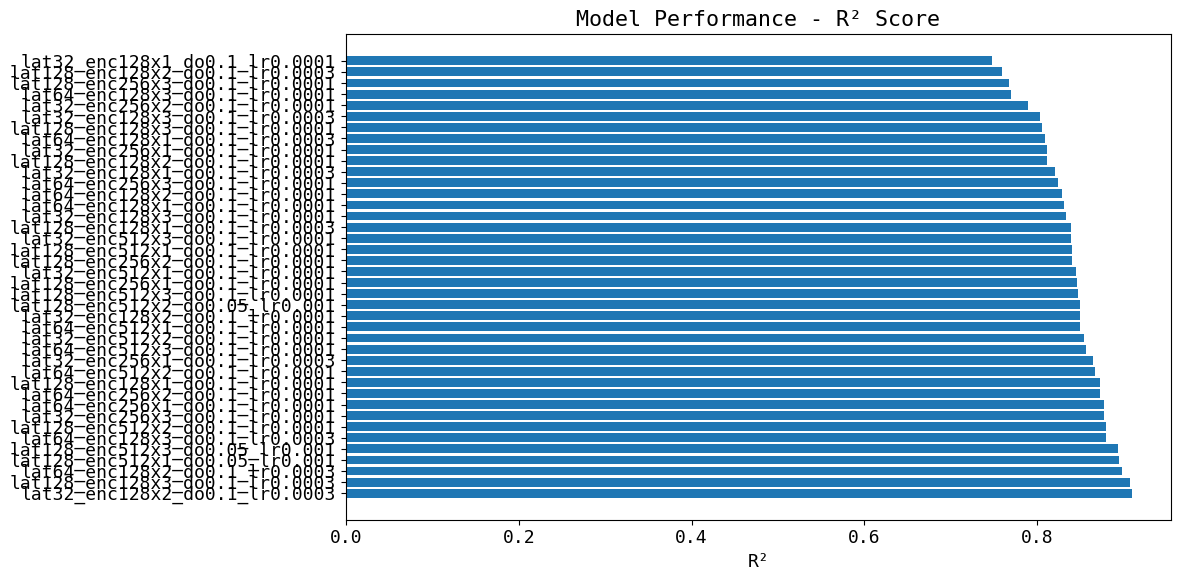

In [4]:
df_sorted = df.sort_values(by="R2", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["R2"])
plt.xlabel("R²")
plt.title("Model Performance - R² Score")
plt.tight_layout()
plt.show()


### Bar plot for MSE

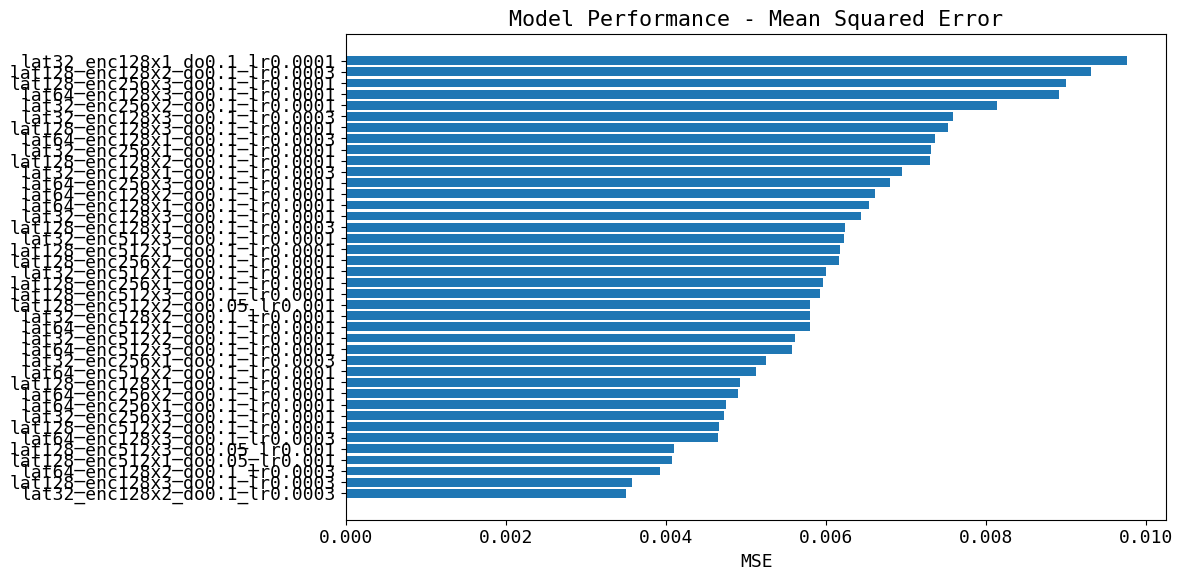

In [5]:
df_sorted = df.sort_values(by="MSE", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["MSE"])
plt.xlabel("MSE")
plt.title("Model Performance - Mean Squared Error")
plt.tight_layout()
plt.show()

### Bar plot for Pearson correlation

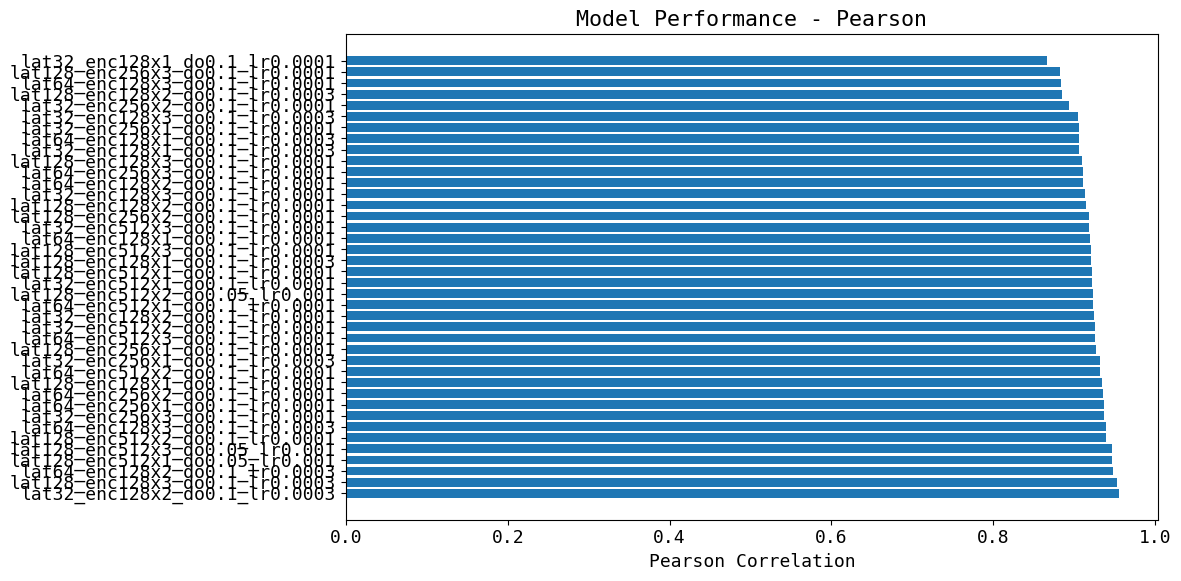

In [6]:
df_sorted = df.sort_values(by="Pearson", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["Pearson"])
plt.xlabel("Pearson Correlation")
plt.title("Model Performance - Pearson")
plt.tight_layout()
plt.show()

###  Bar plot for KDE divergence

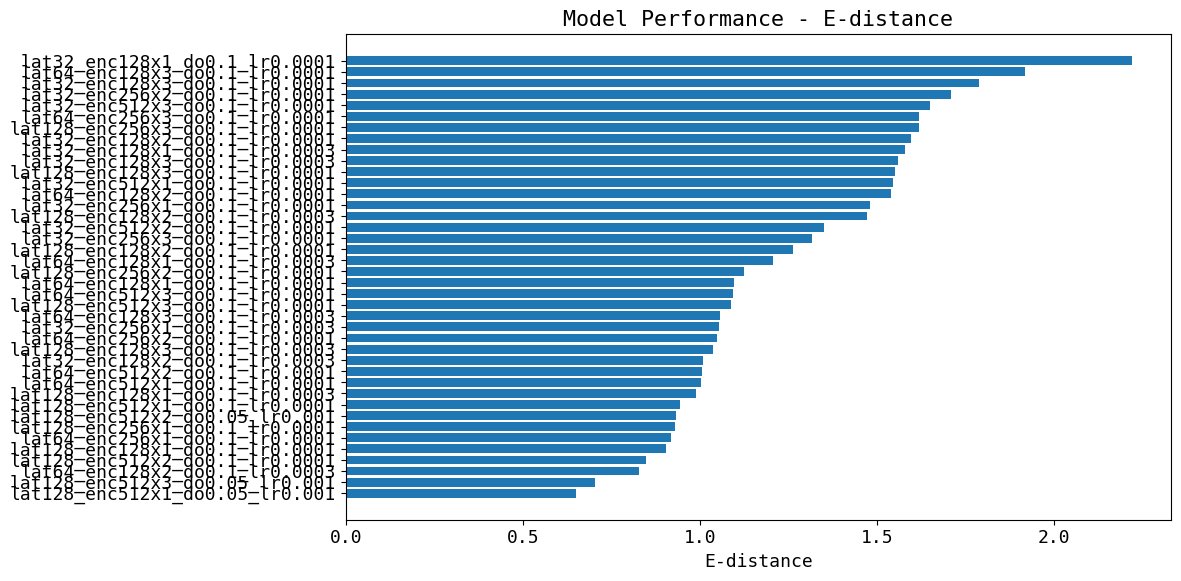

In [7]:
df_sorted = df.sort_values(by="e_distance", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["e_distance"])
plt.xlabel("E-distance")
plt.title("Model Performance - E-distance")
plt.tight_layout()
plt.show()

### Bar plot for Top-100 DEG Jaccard similarity

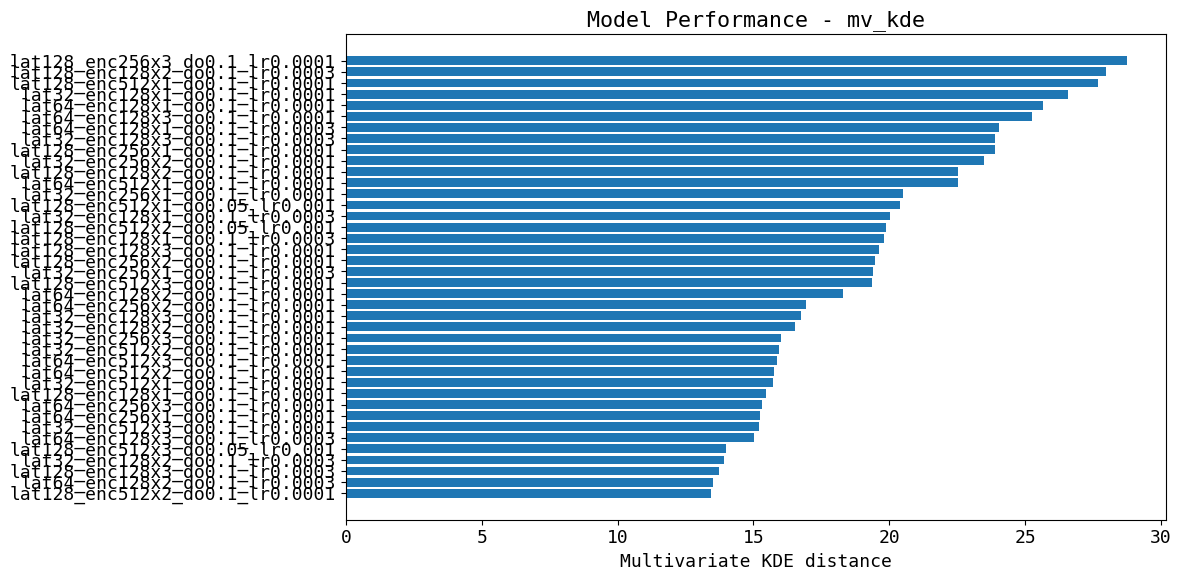

In [8]:
df_sorted = df.sort_values(by="mv_kde", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["mv_kde"])
plt.xlabel("Multivariate KDE distance")
plt.title("Model Performance - mv_kde")
plt.tight_layout()
plt.show()

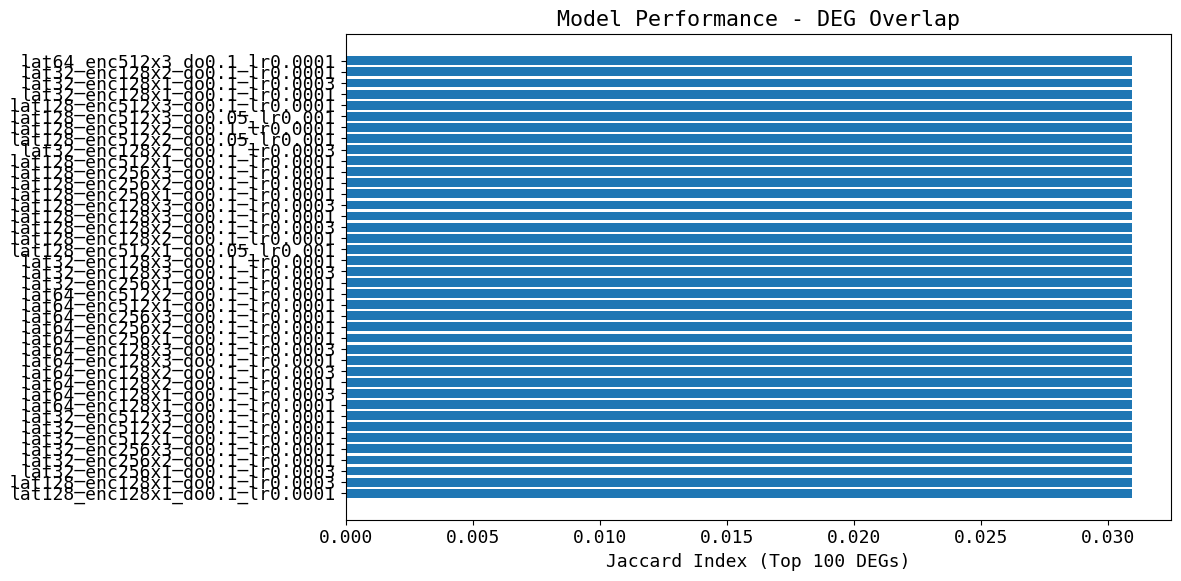

In [9]:
df_sorted = df.sort_values(by="jaccard_top100", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(df_sorted["model"], df_sorted["jaccard_top100"])
plt.xlabel("Jaccard Index (Top 100 DEGs)")
plt.title("Model Performance - DEG Overlap")
plt.tight_layout()
plt.show()